In [2]:
# %pip install CoolProp
# %pip install seaborn
# %pip install openpyxl

In [1]:
import CoolProp.CoolProp as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
import os
import re
import seaborn
import pickle
pf.__version__

'0.0.62'

In [2]:
# Setting plotting parameters
plt.rcParams["font.family"] = 'Times New Roman'
plt.rcParams["font.size"] =12
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["mathtext.fontset"] = "dejavusans"
plt.rcParams['patch.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1 
plt.rcParams["xtick.direction"] = "out"
plt.rcParams["ytick.direction"] = "out"
plt.rcParams["ytick.direction"] = "out"
plt.rcParams["xtick.major.size"] = 6 # Sets length of ticks
plt.rcParams["ytick.major.size"] = 6 # Sets length of ticks
plt.rcParams["xtick.minor.size"] = 3 # Sets length of ticks
plt.rcParams["ytick.minor.size"] = 3 # Sets length of ticks
plt.rcParams["ytick.labelsize"] = 12 # Sets size of numbers on tick marks
plt.rcParams["xtick.labelsize"] = 12 # Sets size of numbers on tick marks
plt.rcParams["axes.titlesize"] = 14 # Overall title
plt.rcParams["axes.labelsize"] = 14 # Axes labels
plt.rcParams["pdf.fonttype"]=42
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["legend.fancybox"]=False

MasterFolder=r"P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Data\Hawaii_FI"
Helperfile_folder=os.path.join(MasterFolder, "Data\Helper_files")

fiolpath=os.path.join(Helperfile_folder, "Devitre_olivine_041223_wtags_mod_062323.xlsx") #r"P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Data\Hawaii_FI\Data\Helper_files\Devitre_olivine_041223_wtags_mod_062323.xlsx"
mipath=os.path.join(Helperfile_folder, "Supplement_Wieser_et_al_G3.xlsx") #r"P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Data\Hawaii_FI\Data\Helper_files\Supplement_Wieser_et_al_G3.xlsx"
mifimatch_path=os.path.join(Helperfile_folder, "pw_MIFI_matchnames.xlsx") #r"P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Data\Hawaii_FI\Data\Helper_files\pw_MIFI_matchnames.xlsx"
Ol_T_model_path=os.path.join(Helperfile_folder, "Ol_T_model.pkl") #r"P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Data\Hawaii_FI\Data\Helper_files\Ol_T_model.pkl"

rep_FI_path=os.path.join(Helperfile_folder, "Leilani_repeated_names.xlsx") #r"P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Data\Hawaii_FI\Data\Helper_files\Leilaini_repeated_names.xlsx"
FI_texture_path=os.path.join(Helperfile_folder, "FI_textures.xlsx") #r"P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Data\Hawaii_FI\Data\Helper_files\FI_textures.xlsx"




#Folder to save figures

figpath=MasterFolder +'\Figs'
if not os.path.exists(figpath):
    os.mkdir(figpath)

#Folder to save full datasets

compilation_folder=MasterFolder +'\Data'+'\Compiled_data'
if not os.path.exists(compilation_folder):
    os.mkdir(compilation_folder)

# This function compiles calibrated data (fit and neon corrected) for each eruption
def compile_calibrated_fits(*,path=None, sheet_name='Sheet1',keyword='Calibration_fitting'):
    files = os.listdir(path)
    files_xls = [f for f in files if keyword in f]
    df=pd.DataFrame()
    for f in files_xls:
        sheets = pd.read_excel(path+'/'+f, sheet_name)
        df = pd.concat([df,sheets],axis=0)
        unnamed_columns = [col for col in df.columns if 'Unnamed' in col]
        df = df.drop(columns=unnamed_columns)
        df['T_K']=1150+273.15
        df=df.reset_index(drop=True)
    return df

In [3]:
lei = r"P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Data\Hawaii_FI\Data\Raman\Leilani-2018\OUTPUT"
kea = r"P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Data\Hawaii_FI\Data\Raman\Keanakakoi\OUTPUT"
uwe = r"P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Data\Hawaii_FI\Data\Raman\Uwekahuna\OUTPUT"
l84 = r"P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Data\Hawaii_FI\Data\Raman\Littoral\OUTPUT"

paths=[lei,kea,uwe,l84]

dfs_dict = {} # Initialize an empty dictionary to store the dataframes
sheet_name='Sheet1'
keyword='FI_fitting_w_sec_phases'

for path in paths:
    df = compile_calibrated_fits(path=path, sheet_name=sheet_name, keyword=keyword)
    dfs_dict[path] = df # Add the dataframe to the dictionary with the path as the key

for p in dfs_dict:
    dfs_dict[p]['filename_4match'] = dfs_dict[p]['filename_x'].str.replace('_CRR_DiadFit', '')
    dfs_dict[p].insert(1, dfs_dict[p].columns[-1], dfs_dict[p].pop(dfs_dict[p].columns[-1]))
    dfs_dict[p]['SO2-CO2_Arearatio']=dfs_dict[p]['Peak_Area_SO2']/(dfs_dict[p]['Diad1_Voigt_Area']+dfs_dict[p]['Diad2_Voigt_Area'])
    dfs_dict[p] = dfs_dict[p].dropna(subset=['Corrected_Splitting'])
    
    dfs_dict[p] = dfs_dict[p][~dfs_dict[p]['filename_4match'].str.contains('de|FO')]
    if p ==lei:
        dfs_dict[p] = dfs_dict[p][dfs_dict[p]['filename_4match'].str.contains('LL')]
    if p ==kea:
        dfs_dict[p] = dfs_dict[p][dfs_dict[p]['filename_4match'].str.contains('K')]
    if p ==uwe:
        dfs_dict[p] = dfs_dict[p][dfs_dict[p]['filename_4match'].str.contains('UW')]
    if p ==l84:
        dfs_dict[p] = dfs_dict[p][dfs_dict[p]['filename_4match'].str.contains('L84')]

for dfs in dfs_dict:
    print (dfs)
    display(dfs_dict[dfs].head(2))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
display(dfs_dict[lei].head())

P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Data\Hawaii_FI\Data\Raman\Leilani-2018\OUTPUT


,Corrected_Splitting,filename_4match,Corr_Split+1σ,Corr_Split-1σ,Corr_Split_1σ_val,filename_x,Splitting,Split_err_abs,Split_err_quadrature,Diad1_Combofit_Cent,...,Model_name,SO2_Diad_Ratio,T_K,Model_name_x,Peak_Cent_Carb,Peak_Area_Carb,Peak_Height_Carb,Model_name_y,Carb_Diad_Ratio,SO2-CO2_Arearatio
1,102.888001,LL4_23-FI#1-rep2,102.905271,102.870731,0.01727,LL4_23-FI#1-rep2_CRR_DiadFit,103.136530,0.017297,0.017297,1285.951866,...,Spline,0.195023,1423.15,NaN,NaN,NaN,NaN,NaN,NaN,0.195023
2,102.872544,LL4_23-FI#1,102.930435,102.814654,0.05789,LL4_23-FI#1_CRR_DiadFit,103.120938,0.078826,0.058026,1285.931252,...,NaN,NaN,1423.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN


P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Data\Hawaii_FI\Data\Raman\Keanakakoi\OUTPUT


,Corrected_Splitting,filename_4match,Corr_Split+1σ,Corr_Split-1σ,Corr_Split_1σ_val,filename_x,Splitting,Split_err_abs,Split_err_quadrature,Diad1_Combofit_Cent,...,Model_name,SO2_Diad_Ratio,T_K,Model_name_x,Peak_Cent_Carb,Peak_Area_Carb,Peak_Height_Carb,Model_name_y,Carb_Diad_Ratio,SO2-CO2_Arearatio
0,103.091854,K21-51rep1,103.105995,103.077713,0.014141,K21-51rep1_CRR_DiadFit,103.309678,0.018763,0.014159,1285.562462,...,NaN,NaN,1423.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,103.106128,K21-51rep2,103.113062,103.099193,0.006934,K21-51rep2_CRR_DiadFit,103.324484,0.009442,0.006924,1285.558238,...,Spline,0.047341,1423.15,NaN,NaN,NaN,NaN,NaN,NaN,0.047341


P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Data\Hawaii_FI\Data\Raman\Uwekahuna\OUTPUT


,Corrected_Splitting,filename_4match,Corr_Split+1σ,Corr_Split-1σ,Corr_Split_1σ_val,filename_x,Splitting,Split_err_abs,Split_err_quadrature,Diad1_Combofit_Cent,...,Model_name_x,Peak_Cent_Carb,Peak_Area_Carb,Peak_Height_Carb,Model_name_y,Carb_Diad_Ratio,SO2_Diad_Ratio,T_K,Model_name,SO2-CO2_Arearatio
18,103.014396,UW7-OX1-mX1-FI#1,103.022948,103.005844,0.008552,UW7-OX1-mX1-FI#1,103.230561,0.011651,0.008538,1285.680633,...,Spline,NaN,NaN,NaN,NaN,NaN,0.044553,1423.15,NaN,0.044553
19,102.984105,UW7-OX1-mX2-FI#1,102.990817,102.977393,0.006712,UW7-OX1-mX2-FI#1_CRR_DiadFit,103.201068,0.009329,0.006685,1285.699728,...,Spline,NaN,NaN,NaN,NaN,NaN,0.107452,1423.15,NaN,0.107452


P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Data\Hawaii_FI\Data\Raman\Littoral\OUTPUT


,Corrected_Splitting,filename_4match,Corr_Split+1σ,Corr_Split-1σ,Corr_Split_1σ_val,filename_x,Splitting,Split_err_abs,Split_err_quadrature,Diad1_Combofit_Cent,...,Peak_Height_SO2,Model_name_x,Peak_Cent_Carb,Peak_Area_Carb,Peak_Height_Carb,Model_name_y,Carb_Diad_Ratio,SO2_Diad_Ratio,T_K,SO2-CO2_Arearatio
0,103.556950,L84-FI40-FI#1,103.568019,103.545881,0.011069,L84-FI40-FI#1_CRR_DiadFit,103.796127,0.015568,0.011071,1284.507062,...,NaN,NaN,1087.523424,320.870109,12.932434,PseudoVoigtModel,0.037921,NaN,1423.15,NaN
1,103.008168,L84-FI41-FI#1,103.024995,102.991341,0.016827,L84-FI41-FI#1_CRR_DiadFit,103.246027,0.023243,0.016851,1285.819087,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1423.15,NaN


,Corrected_Splitting,filename_4match,Corr_Split+1σ,Corr_Split-1σ,Corr_Split_1σ_val,filename_x,Splitting,Split_err_abs,Split_err_quadrature,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,Diad1_Prop_Lor,Diad1_fwhm,Diad1_refit,Diad2_Combofit_Cent,Diad2_cent_err,Diad2_Combofit_Height,Diad2_Voigt_Cent,Diad2_Voigt_Area,Diad2_Voigt_Sigma,Diad2_Voigt_Gamma,Diad2_Residual,Diad2_Prop_Lor,Diad2_fwhm,Diad2_refit,HB1_Cent,HB1_Area,HB1_Sigma,HB2_Cent,HB2_Area,HB2_Sigma,C13_Cent,C13_Area,C13_Sigma,Diad2_Gauss_Cent,Diad2_Gauss_Area,Diad2_Gauss_Sigma,Diad1_Gauss_Cent,Diad1_Gauss_Area,Diad1_Gauss_Sigma,name_for_matching,Name_for_Secondary_Phases,filename_y,date,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center,filename,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,Model_name,SO2_Diad_Ratio,T_K,Model_name_x,Peak_Cent_Carb,Peak_Area_Carb,Peak_Height_Carb,Model_name_y,Carb_Diad_Ratio,SO2-CO2_Arearatio
1,102.888001,LL4_23-FI#1-rep2,102.905271,102.870731,0.017270,LL4_23-FI#1-rep2_CRR_DiadFit,103.136530,0.017297,0.017297,1285.951866,0.017297,122.513583,1285.951866,139.089264,0.463812,3.161550,3.961196e-01,0.927624,Flagged Warnings:,1389.088397,0.000000,198.919597,1389.088397,221.845561,0.468070,0.0,3.236064,3.333498e-01,0.936141,Flagged Warnings: No Error,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LL4_23-FI#1-rep2,LL4_23-FI#1-rep2,LL4_23-FI#1-rep2.txt,"April 5, 2023\n",April,5,11.978,200,2,100,"['0h', '6m', '42s']",3:36:23 PM\n,56183,1325.004,LL4_23-FI#1-rep2.txt,1150.976061,70.3907,37.142668,Spline,0.195023,1423.15,NaN,NaN,NaN,NaN,NaN,NaN,0.195023
2,102.872544,LL4_23-FI#1,102.930435,102.814654,0.057890,LL4_23-FI#1_CRR_DiadFit,103.120938,0.078826,0.058026,1285.931252,0.050820,101.871555,1285.931252,62.667583,0.195090,3.255336,9.997407e-01,0.390180,Flagged Warnings:,1389.052190,0.028006,59.440209,1389.052190,67.748913,0.536886,0.0,2.817462,1.154200e-07,1.073771,Flagged Warnings:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LL4_23-FI#1,LL4_23-FI#1,LL4_23-FI#1.txt,"April 5, 2023\n",April,5,11.961,45,1,100,"['0h', '1m', '26s']",3:27:43 PM\n,55663,1325.004,NaN,NaN,NaN,NaN,NaN,NaN,1423.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,102.733671,LL4_27-MI#1,102.820066,102.647277,0.086394,LL4_27-MI#1_CRR_DiadFit,102.981339,0.116566,0.086599,1286.368205,0.077066,13.206776,1286.368205,11.838700,0.417064,1.555193,2.612780e-07,0.834129,Flagged Warnings:,1389.349544,0.039500,17.324627,1389.349544,14.044753,0.378381,0.0,1.402058,2.559355e-07,0.756762,Flagged Warnings:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LL4_27-MI#1,LL4_27-MI#1,LL4_27-MI#1.txt,"April 5, 2023\n",April,5,11.945,45,5,50,"['0h', '3m', '46s']",2:57:10 PM\n,53830,1325.004,NaN,NaN,NaN,NaN,NaN,NaN,1423.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,102.909069,LL7_114-FI#1,102.914475,102.903663,0.005406,LL7_114-FI#1,103.158063,0.007524,0.005374,1285.942820,0.004296,300.522041,1285.942820,358.376321,0.477553,2.061422,4.582732e-01,0.955106,Flagged Warnings:,1389.100883,0.003228,479.646668,1389.100883,539.252824,0.461568,0.0,2.128226,3.930627e-01,0.923136,Flagged Warnings:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LL7_114-FI#1,LL7_114-FI#1,LL7_114-FI#1.txt,"April 5, 2023\n",April,5,12.012,45,5,50,"['0h', '3m', '46s']",4:20:27 PM\n,58827,1325.004,NaN,NaN,NaN,NaN,NaN,NaN,1423.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,103.290522,LL7_114-FI#2,103.297083,103.283962,0.006561,LL7_114-FI#2_CRR_DiadFit,103.540506,0.009041,0.006539,1284.974301,0.005491,495.888592,1284.974301,977.243211,0.718800,3.399226,6.958517e-01,1.437600,Flagged Warnings:,1388.514807,0.003550,930.867062,1388.514807,1492.834604,0.606649,0.0,3.762886,6.082337e-01,1.213299,Flagged Warnings:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LL7_114-FI#2,LL7_114-FI#2,LL7_114-FI#2.txt,"April 5, 2023\n",April,5,12.023,45,5,100,"['0h', '3m', '46s']",4:29:21 PM\n,59361,1325.004,NaN

In [4]:
dfs_dict[lei].to_clipboard(excel=True)

In [5]:
## Merge in the FO content of olivine

### LOAD MELT INCLUSIONS FROM LEILANI

fiol=pd.read_excel(fiolpath, 'Probe_FI')
fiol.columns = [col.strip() for col in fiol.columns]
mw_O=15.999
mw_Mg=24.305
mw_Fe=55.845
mw_MgO=mw_O+mw_Mg
mw_FeO=mw_Fe+mw_O

FeO=fiol['FeO']
MgO=fiol['MgO']

#Calculate Fo (molar) with oxides
mol_FeO=FeO/(mw_FeO)
mol_MgO=MgO/(mw_MgO)
Fo_mol=mol_MgO/(mol_MgO+mol_FeO) #Fo content (molar)

#To calculate Fo using moles of element
Fe=FeO*(mw_Fe/(mw_Fe+mw_O))/100 #(weight)
Mg=MgO*(mw_Mg/(mw_O+mw_Mg))/100 #(weight)
mol_Fe=Fe/mw_Fe
mol_Mg=Mg/mw_Mg
Fo_ele_mol=mol_Mg/(mol_Mg+mol_Fe)

# Add Fo column to probe data

fiol['Fo content (molar)']= Fo_mol*100


dfs_wProbe_dict={}

for dfs in dfs_dict:

    test_df=dfs_dict[dfs]
    results_df = pd.DataFrame()

    for i in fiol.index:
        finame=fiol['FI_name'][i]
        df=test_df[['filename_x']][test_df['filename_4match'].str.contains(finame)].copy()
        
        for col in fiol.columns:
            df[col]=fiol[col][i]
        results_df = pd.concat([results_df, df])

        # if i<=3:
        #     display(df)
        # else:
        #     break

    merge_test=pd.merge(left=test_df,right=results_df,on='filename_x',how='left')
    dfs_wProbe_dict[dfs]=merge_test

# Display the results
for dfs in dfs_wProbe_dict:
    print (dfs)
    display(dfs_wProbe_dict[dfs].head(2))

# # Create a dataframe that contans all the samples and export to excel.
Full_df=pd.concat(dfs_wProbe_dict.values(), ignore_index=True)
Full_df.to_excel(compilation_folder+'/'+'Full_df.xlsx')


C:\Users\charl\AppData\Local\Temp\ipykernel_30804\2578152260.py:42: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df=test_df[['filename_x']][test_df['filename_4match'].str.contains(finame)].copy()
C:\Users\charl\AppData\Local\Temp\ipykernel_30804\2578152260.py:42: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df=test_df[['filename_x']][test_df['filename_4match'].str.contains(finame)].copy()
C:\Users\charl\AppData\Local\Temp\ipykernel_30804\2578152260.py:42: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df=test_df[['filename_x']][test_df['filename_4match'].str.contains(finame)].copy()
C:\Users\charl\AppData\Local\Temp\ipykernel_30804\2578152260.py:42: UserWarning: This pattern is interpreted as a regular expression, and has 

P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Data\Hawaii_FI\Data\Raman\Leilani-2018\OUTPUT


,Corrected_Splitting,filename_4match,Corr_Split+1σ,Corr_Split-1σ,Corr_Split_1σ_val,filename_x,Splitting,Split_err_abs,Split_err_quadrature,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,Diad1_Prop_Lor,Diad1_fwhm,Diad1_refit,Diad2_Combofit_Cent,Diad2_cent_err,Diad2_Combofit_Height,Diad2_Voigt_Cent,Diad2_Voigt_Area,Diad2_Voigt_Sigma,Diad2_Voigt_Gamma,Diad2_Residual,Diad2_Prop_Lor,Diad2_fwhm,Diad2_refit,HB1_Cent,HB1_Area,HB1_Sigma,HB2_Cent,HB2_Area,HB2_Sigma,C13_Cent,C13_Area,C13_Sigma,Diad2_Gauss_Cent,Diad2_Gauss_Area,Diad2_Gauss_Sigma,Diad1_Gauss_Cent,Diad1_Gauss_Area,Diad1_Gauss_Sigma,name_for_matching,Name_for_Secondary_Phases,filename_y,date,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center,filename,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,Model_name,SO2_Diad_Ratio,T_K,Model_name_x,Peak_Cent_Carb,Peak_Area_Carb,Peak_Height_Carb,Model_name_y,Carb_Diad_Ratio,SO2-CO2_Arearatio,Number order,MOUNT,Probe no.,Probe_name,FI_name,Comments,Weight P,CaO,TiO2,SiO2,Al2O3,MgO,FeO,MnO,NiO,Cr2O3,Total,Fo,Cation,Ca,Ti,Si,Al,Mg,Fe,Mn,Ni,Cr,Total .1,Counting_stats,Ca(Error%),Ti(Error%),Si(Error%),Al(Error%),Mg(Error%),Fe(Error%),Mn(Error%),Ni(Error%),Cr(Error%),D.L,Ca(D.L.),Ti(D.L.),Si(D.L.),Al(D.L.),Mg(D.L.),Fe(D.L.),Mn(D.L.),Ni(D.L.),Cr(D.L.),Fo content (molar)
0,102.888001,LL4_23-FI#1-rep2,102.905271,102.870731,0.01727,LL4_23-FI#1-rep2_CRR_DiadFit,103.136530,0.017297,0.017297,1285.951866,0.017297,122.513583,1285.951866,139.089264,0.463812,3.161550,0.396120,0.927624,Flagged Warnings:,1389.088397,0.000000,198.919597,1389.088397,221.845561,0.468070,0.0,3.236064,3.333498e-01,0.936141,Flagged Warnings: No Error,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LL4_23-FI#1-rep2,LL4_23-FI#1-rep2,LL4_23-FI#1-rep2.txt,"April 5, 2023\n",April,5,11.978,200,2,100,"['0h', '6m', '42s']",3:36:23 PM\n,56183,1325.004,LL4_23-FI#1-rep2.txt,1150.976061,70.3907,37.142668,Spline,0.195023,1423.15,NaN,NaN,NaN,NaN,NaN,NaN,0.195023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,102.872544,LL4_23-FI#1,102.930435,102.814654,0.05789,LL4_23-FI#1_CRR_DiadFit,103.120938,0.078826,0.058026,1285.931252,0.050820,101.871555,1285.931252,62.667583,0.195090,3.255336,0.999741,0.390180,Flagged Warnings:,1389.052190,0.028006,59.440209,1389.052190,67.748913,0.536886,0.0,2.817462,1.154200e-07,1.073771,Flagged Warnings:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LL4_23-FI#1,LL4_23-FI#1,LL4_23-FI#1.txt,"April 5, 2023\n",April,5,11.961,45,1,100,"['0h', '1m', '26s']",3:27:43 PM\n,55663,1325.004,NaN,NaN,NaN,NaN,NaN,NaN,1423.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Data\Hawaii_FI\Data\Raman\Keanakakoi\OUTPUT


,Corrected_Splitting,filename_4match,Corr_Split+1σ,Corr_Split-1σ,Corr_Split_1σ_val,filename_x,Splitting,Split_err_abs,Split_err_quadrature,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,Diad1_Prop_Lor,Diad1_fwhm,Diad1_refit,Diad2_Combofit_Cent,Diad2_cent_err,Diad2_Combofit_Height,Diad2_Voigt_Cent,Diad2_Voigt_Area,Diad2_Voigt_Sigma,Diad2_Voigt_Gamma,Diad2_Residual,Diad2_Prop_Lor,Diad2_fwhm,Diad2_refit,HB1_Cent,HB1_Area,HB1_Sigma,HB2_Cent,HB2_Area,HB2_Sigma,C13_Cent,C13_Area,C13_Sigma,Diad2_Gauss_Cent,Diad2_Gauss_Area,Diad2_Gauss_Sigma,Diad1_Gauss_Cent,Diad1_Gauss_Area,Diad1_Gauss_Sigma,name_for_matching,Name_for_Secondary_Phases,filename_y,date,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center,filename,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,Model_name,SO2_Diad_Ratio,T_K,Model_name_x,Peak_Cent_Carb,Peak_Area_Carb,Peak_Height_Carb,Model_name_y,Carb_Diad_Ratio,SO2-CO2_Arearatio,Number order,MOUNT,Probe no.,Probe_name,FI_name,Comments,Weight P,CaO,TiO2,SiO2,Al2O3,MgO,FeO,MnO,NiO,Cr2O3,Total,Fo,Cation,Ca,Ti,Si,Al,Mg,Fe,Mn,Ni,Cr,Total .1,Counting_stats,Ca(Error%),Ti(Error%),Si(Error%),Al(Error%),Mg(Error%),Fe(Error%),Mn(Error%),Ni(Error%),Cr(Error%),D.L,Ca(D.L.),Ti(D.L.),Si(D.L.),Al(D.L.),Mg(D.L.),Fe(D.L.),Mn(D.L.),Ni(D.L.),Cr(D.L.),Fo content (molar)
0,103.091854,K21-51rep1,103.105995,103.077713,0.014141,K21-51rep1_CRR_DiadFit,103.309678,0.018763,0.014159,1285.562462,0.012877,178.657262,1285.562462,275.331583,0.575825,3.023565,0.639633,1.151650,Flagged Warnings:,1388.872140,0.005886,343.665351,1388.872140,443.408543,0.461923,0,3.020989,0.742333,0.923847,Flagged Warnings:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K21-51rep1,K21-51rep1,K21-51rep1.txt,"October 26, 2022\n",October,26,12.075,45,5,50,"['0h', '3m', '47s']",11:53:53 AM\n,42833,1325.004,NaN,NaN,NaN,NaN,NaN,NaN,1423.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111.0,2 (CLJD),318.0,K21-51_1,K21-51,"rep1,2,3",NaN,0.235,0.026,39.971,0.035,45.053,14.677,0.191,0.29,0.064,100.542,NaN,NaN,0.0063,0.0005,0.998,0.001,1.6769,0.3065,0.004,0.0058,0.0013,3.0004,NaN,4.72,52.47,0.25,25.85,0.21,0.56,6.89,2.97,12.01,NaN,69.0,95.0,115.0,43.0,48.0,95.0,83.0,54.0,63.0,84.548305
1,103.106128,K21-51rep2,103.113062,103.099193,0.006934,K21-51rep2_CRR_DiadFit,103.324484,0.009442,0.006924,1285.558238,0.006018,333.530278,1285.558238,499.969430,0.564306,2.572277,0.617022,1.128611,Flagged Warnings:,1388.882722,0.003424,596.966826,1388.882722,777.279063,0.499185,0,2.704608,0.573147,0.998370,Flagged Warnings:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K21-51rep2,K21-51rep2,K21-51rep2.txt,"October 26, 2022\n",October,26,12.095,45,5,50,"['0h', '3m', '46s']",12:00:22 PM\n,43222,1325.004,K21-51rep2.txt,1150.858072,60.466785,32.878383,Spline,0.047341,1423.15,NaN,NaN,NaN,NaN,NaN,NaN,0.047341,111.0,2 (CLJD),318.0,K21-51_1,K21-51,"rep1,2,3",NaN,0.235,0.026,39.971,0.035,45.053,14.677,0.191,0.29,0.064,100.542,NaN,NaN,0.0063,0.0005,0.998,0.001,1.6769,0.3065,0.004,0.0058,0.0013,3.0004,NaN,4.72,52.47,0.25,25.85,0.21,0.56,6.89,2.97,12.01,NaN,69.0,95.0,115.0,43.0,48.0,95.0,83.0,54.0,63.0,84.548305


P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Data\Hawaii_FI\Data\Raman\Uwekahuna\OUTPUT


,Corrected_Splitting,filename_4match,Corr_Split+1σ,Corr_Split-1σ,Corr_Split_1σ_val,filename_x,Splitting,Split_err_abs,Split_err_quadrature,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,Diad1_Prop_Lor,Diad1_fwhm,Diad1_refit,Diad2_Combofit_Cent,Diad2_cent_err,Diad2_Combofit_Height,Diad2_Voigt_Cent,Diad2_Voigt_Area,Diad2_Voigt_Sigma,Diad2_Voigt_Gamma,Diad2_Residual,Diad2_Prop_Lor,Diad2_fwhm,Diad2_refit,HB1_Cent,HB1_Area,HB1_Sigma,HB2_Cent,HB2_Area,HB2_Sigma,C13_Cent,C13_Area,C13_Sigma,Diad2_Gauss_Cent,Diad2_Gauss_Area,Diad2_Gauss_Sigma,Diad1_Gauss_Cent,Diad1_Gauss_Area,Diad1_Gauss_Sigma,name_for_matching,Name_for_Secondary_Phases,filename_y,date,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center,filename,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,Model_name_x,Peak_Cent_Carb,Peak_Area_Carb,Peak_Height_Carb,Model_name_y,Carb_Diad_Ratio,SO2_Diad_Ratio,T_K,Model_name,SO2-CO2_Arearatio,Number order,MOUNT,Probe no.,Probe_name,FI_name,Comments,Weight P,CaO,TiO2,SiO2,Al2O3,MgO,FeO,MnO,NiO,Cr2O3,Total,Fo,Cation,Ca,Ti,Si,Al,Mg,Fe,Mn,Ni,Cr,Total .1,Counting_stats,Ca(Error%),Ti(Error%),Si(Error%),Al(Error%),Mg(Error%),Fe(Error%),Mn(Error%),Ni(Error%),Cr(Error%),D.L,Ca(D.L.),Ti(D.L.),Si(D.L.),Al(D.L.),Mg(D.L.),Fe(D.L.),Mn(D.L.),Ni(D.L.),Cr(D.L.),Fo content (molar)
0,103.014396,UW7-OX1-mX1-FI#1,103.022948,103.005844,0.008552,UW7-OX1-mX1-FI#1,103.230561,0.011651,0.008538,1285.680633,0.007411,411.474791,1285.680633,602.489815,0.560506,3.673851,0.575773,1.121013,Flagged Warnings:,1388.911194,0.004240,774.58997,1388.911194,918.371495,0.469539,0.0,4.034387,0.491235,0.939078,Flagged Warnings:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UW7-OX1-mX1-FI#1,UW7-OX1-mX1-FI#1,UW7-OX1-mX1-FI#1.txt,"November 3, 2022\n",November,3,12.028,45,5,50,"['0h', '3m', '46s']",4:03:29 PM\n,57809,1325.004,UW7-OX1-mX1-FI#1.txt,1150.858072,67.759592,42.770716,Spline,NaN,NaN,NaN,NaN,NaN,0.044553,1423.15,NaN,0.044553,170.0,2 (CLJD),440.0,UW7-1_1,UW7-OX1-mX1-FI#1,NaN,NaN,0.233,0.026,40.793,0.056,49.003,9.918,0.119,0.457,0.108,100.713,NaN,NaN,0.0061,0.0005,0.9955,0.0016,1.7826,0.2024,0.0025,0.0090,0.0021,3.0024,NaN,4.60,51.04,0.25,16.23,0.19,0.68,9.83,2.10,7.65,NaN,72.0,99.0,113.0,42.0,47.0,102.0,85.0,54.0,62.0,89.803474
1,102.984105,UW7-OX1-mX2-FI#1,102.990817,102.977393,0.006712,UW7-OX1-mX2-FI#1_CRR_DiadFit,103.201068,0.009329,0.006685,1285.699728,0.005432,561.415618,1285.699728,788.974612,0.545593,3.872382,0.542297,1.091186,Flagged Warnings:,1388.900796,0.003897,1013.24126,1388.900796,1199.789264,0.462551,0.0,4.304216,0.524997,0.925103,Flagged Warnings:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UW7-OX1-mX2-FI#1,UW7-OX1-mX2-FI#1,UW7-OX1-mX2-FI#1.txt,"November 3, 2022\n",November,3,12.039,45,5,50,"['0h', '3m', '46s']",4:23:27 PM\n,59007,1325.004,UW7-OX1-mX2-FI#1.txt,1150.858072,213.696463,135.233789,Spline,NaN,NaN,NaN,NaN,NaN,0.107452,1423.15,NaN,0.107452,172.0,2 (CLJD),442.0,UW7-1_3,UW7-OX1-mX2-FI#1,NaN,NaN,0.234,0.012,40.663,0.052,48.971,9.963,0.128,0.451,0.104,100.578,NaN,NaN,0.0061,0.0002,0.9941,0.0015,1.7847,0.2037,0.0026,0.0089,0.0020,3.0039,NaN,4.67,110.23,0.25,17.58,0.19,0.68,9.04,2.13,7.82,NaN,90.0,121.0,135.0,50.0,52.0,99.0,89.0,53.0,62.0,89.755942


P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Data\Hawaii_FI\Data\Raman\Littoral\OUTPUT


,Corrected_Splitting,filename_4match,Corr_Split+1σ,Corr_Split-1σ,Corr_Split_1σ_val,filename_x,Splitting,Split_err_abs,Split_err_quadrature,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,Diad1_Prop_Lor,Diad1_fwhm,Diad1_refit,Diad2_Combofit_Cent,Diad2_cent_err,Diad2_Combofit_Height,Diad2_Voigt_Cent,Diad2_Voigt_Area,Diad2_Voigt_Sigma,Diad2_Voigt_Gamma,Diad2_Residual,Diad2_Prop_Lor,Diad2_fwhm,Diad2_refit,HB1_Cent,HB1_Area,HB1_Sigma,HB2_Cent,HB2_Area,HB2_Sigma,C13_Cent,C13_Area,C13_Sigma,Diad2_Gauss_Cent,Diad2_Gauss_Area,Diad2_Gauss_Sigma,Diad1_Gauss_Cent,Diad1_Gauss_Area,Diad1_Gauss_Sigma,name_for_matching,Name_for_Secondary_Phases,filename_y,date,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center,filename,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,Model_name_x,Peak_Cent_Carb,Peak_Area_Carb,Peak_Height_Carb,Model_name_y,Carb_Diad_Ratio,SO2_Diad_Ratio,T_K,SO2-CO2_Arearatio,Number order,MOUNT,Probe no.,Probe_name,FI_name,Comments,Weight P,CaO,TiO2,SiO2,Al2O3,MgO,FeO,MnO,NiO,Cr2O3,Total,Fo,Cation,Ca,Ti,Si,Al,Mg,Fe,Mn,Ni,Cr,Total .1,Counting_stats,Ca(Error%),Ti(Error%),Si(Error%),Al(Error%),Mg(Error%),Fe(Error%),Mn(Error%),Ni(Error%),Cr(Error%),D.L,Ca(D.L.),Ti(D.L.),Si(D.L.),Al(D.L.),Mg(D.L.),Fe(D.L.),Mn(D.L.),Ni(D.L.),Cr(D.L.),Fo content (molar)
0,103.556950,L84-FI40-FI#1,103.568019,103.545881,0.011069,L84-FI40-FI#1_CRR_DiadFit,103.796127,0.015568,0.011071,1284.507062,0.008616,1305.641042,1284.507062,3291.029890,0.942312,13.826061,0.637945,1.884623,Flagged Warnings:,1388.303189,0.006952,2726.681780,1388.303189,5170.566360,0.706351,0,17.704693,0.646923,1.412701,Flagged Warnings:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L84-FI40-FI#1,L84-FI40-FI#1,L84-FI40-FI#1.txt,"November 11, 2022\n",November,11,11.989,45,5,50,"['0h', '3m', '46s']",3:52:12 PM\n,57132,1325.004,L84-FI40-FI#1.txt,NaN,NaN,NaN,NaN,1087.523424,320.870109,12.932434,PseudoVoigtModel,0.037921,NaN,1423.15,NaN,95,2 (CLJD),299.0,L84-40_1,L84-FI40-FI#1,NaN,NaN,0.250,0.018,40.547,0.035,47.431,11.417,0.179,0.429,0.092,100.398,NaN,NaN,0.0066,0.0003,0.9993,0.0010,1.7425,0.2353,0.0037,0.0085,0.0018,2.9991,NaN,4.35,78.01,0.25,26.05,0.2,0.63,6.90,2.2,8.47,NaN,69.0,97.0,112.0,41.0,46.0,98.0,87.0,54.0,61.0,88.102985
1,103.008168,L84-FI41-FI#1,103.024995,102.991341,0.016827,L84-FI41-FI#1_CRR_DiadFit,103.246027,0.023243,0.016851,1285.819087,0.014251,1257.322700,1285.819087,1733.783136,0.519030,22.328823,0.621934,1.038059,Flagged Warnings:,1389.065113,0.008991,2037.690108,1389.065113,2335.755125,0.462067,0,32.857847,0.439211,0.924133,Flagged Warnings:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L84-FI41-FI#1,L84-FI41-FI#1,L84-FI41-FI#1.txt,"November 11, 2022\n",November,11,11.985,45,5,50,"['0h', '3m', '46s']",3:59:53 PM\n,57593,1325.004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1423.15,NaN,96,2 (CLJD),300.0,L84-41_1,L84-FI41-FI#1,NaN,NaN,0.233,0.000,40.409,0.059,48.042,11.012,0.136,0.406,0.100,100.397,NaN,NaN,0.0061,0.0000,0.9943,0.0017,1.7622,0.2266,0.0028,0.0080,0.0019,3.0036,NaN,4.65,100.00,0.25,15.49,0.2,0.64,8.97,2.3,8.08,NaN,70.0,102.0,115.0,44.0,49.0,95.0,90.0,55.0,64.0,88.606240


## Convert splitting to density and filter out negative densities
- Here we use the UCB densimeter, and use the supercritical arguement, as analyses were done at 37C. 

In [6]:
density_dict={}
dfs_wProbe_dict_filt={}
temp='SupCrit'

for dfs in dfs_wProbe_dict:
    density=pf.calculate_density_ucb(temp=temp, Split=dfs_wProbe_dict[dfs]['Corrected_Splitting'],split_err=dfs_wProbe_dict[dfs]['Corr_Split_1σ_val'])
    density_dict[dfs]=density

    for col in density_dict[dfs].columns:
        dfs_wProbe_dict[dfs][col]=density_dict[dfs][col]

    dfs_wProbe_dict_filt[dfs]=dfs_wProbe_dict[dfs][dfs_wProbe_dict[dfs]['Preferred D']>0]

# Display the results
for dfs in dfs_wProbe_dict_filt:
    print(dfs)
    print(len(dfs_wProbe_dict_filt[dfs]))
    display(dfs_wProbe_dict_filt[dfs].head(2))

P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Data\Hawaii_FI\Data\Raman\Leilani-2018\OUTPUT
224


,Corrected_Splitting,filename_4match,Corr_Split+1σ,Corr_Split-1σ,Corr_Split_1σ_val,filename_x,Splitting,Split_err_abs,Split_err_quadrature,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,Diad1_Prop_Lor,Diad1_fwhm,Diad1_refit,Diad2_Combofit_Cent,Diad2_cent_err,Diad2_Combofit_Height,Diad2_Voigt_Cent,Diad2_Voigt_Area,Diad2_Voigt_Sigma,Diad2_Voigt_Gamma,Diad2_Residual,Diad2_Prop_Lor,Diad2_fwhm,Diad2_refit,HB1_Cent,HB1_Area,HB1_Sigma,HB2_Cent,HB2_Area,HB2_Sigma,C13_Cent,C13_Area,C13_Sigma,Diad2_Gauss_Cent,Diad2_Gauss_Area,Diad2_Gauss_Sigma,Diad1_Gauss_Cent,Diad1_Gauss_Area,Diad1_Gauss_Sigma,name_for_matching,Name_for_Secondary_Phases,filename_y,date,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center,filename,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,Model_name,SO2_Diad_Ratio,T_K,Model_name_x,Peak_Cent_Carb,Peak_Area_Carb,Peak_Height_Carb,Model_name_y,Carb_Diad_Ratio,SO2-CO2_Arearatio,Number order,MOUNT,Probe no.,Probe_name,FI_name,Comments,Weight P,CaO,TiO2,SiO2,Al2O3,MgO,FeO,MnO,NiO,Cr2O3,Total,Fo,Cation,Ca,Ti,Si,Al,Mg,Fe,Mn,Ni,Cr,Total .1,Counting_stats,Ca(Error%),Ti(Error%),Si(Error%),Al(Error%),Mg(Error%),Fe(Error%),Mn(Error%),Ni(Error%),Cr(Error%),D.L,Ca(D.L.),Ti(D.L.),Si(D.L.),Al(D.L.),Mg(D.L.),Fe(D.L.),Mn(D.L.),Ni(D.L.),Cr(D.L.),Fo content (molar),Preferred D,dens-1σ,dens+1σ,1σ,in range,Notes,LowD_RT,HighD_RT,LowD_SC,MedD_SC,HighD_SC,Temperature
0,102.888001,LL4_23-FI#1-rep2,102.905271,102.870731,0.01727,LL4_23-FI#1-rep2_CRR_DiadFit,102.888001,0.017297,0.017297,1285.951866,0.017297,122.513583,1285.951866,139.089264,0.463812,3.161550,0.396120,0.927624,Flagged Warnings:,1389.088397,0.000000,198.919597,1389.088397,221.845561,0.468070,0.0,3.236064,3.333498e-01,0.936141,Flagged Warnings: No Error,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LL4_23-FI#1-rep2,LL4_23-FI#1-rep2,LL4_23-FI#1-rep2.txt,"April 5, 2023\n",April,5,11.978,200,2,100,"['0h', '6m', '42s']",3:36:23 PM\n,56183,1325.004,LL4_23-FI#1-rep2.txt,1150.976061,70.3907,37.142668,Spline,0.195023,1423.15,NaN,NaN,NaN,NaN,NaN,NaN,0.195023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.054505,0.047667,0.061343,0.006838,Y,"SupCrit, low density",0.057439,-0.342823,0.054505,0.056879,-0.188250,SupCrit
1,102.872544,LL4_23-FI#1,102.930435,102.814654,0.05789,LL4_23-FI#1_CRR_DiadFit,102.872544,0.078826,0.058026,1285.931252,0.050820,101.871555,1285.931252,62.667583,0.195090,3.255336,0.999741,0.390180,Flagged Warnings:,1389.052190,0.028006,59.440209,1389.052190,67.748913,0.536886,0.0,2.817462,1.154200e-07,1.073771,Flagged Warnings:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LL4_23-FI#1,LL4_23-FI#1,LL4_23-FI#1.txt,"April 5, 2023\n",April,5,11.961,45,1,100,"['0h', '1m', '26s']",3:27:43 PM\n,55663,1325.004,NaN,NaN,NaN,NaN,NaN,NaN,1423.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.048385,0.025463,0.071307,0.022922,Y,"SupCrit, low density",0.051670,-0.357099,0.048385,0.050745,-0.200087,SupCrit


P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Data\Hawaii_FI\Data\Raman\Keanakakoi\OUTPUT
79


,Corrected_Splitting,filename_4match,Corr_Split+1σ,Corr_Split-1σ,Corr_Split_1σ_val,filename_x,Splitting,Split_err_abs,Split_err_quadrature,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,Diad1_Prop_Lor,Diad1_fwhm,Diad1_refit,Diad2_Combofit_Cent,Diad2_cent_err,Diad2_Combofit_Height,Diad2_Voigt_Cent,Diad2_Voigt_Area,Diad2_Voigt_Sigma,Diad2_Voigt_Gamma,Diad2_Residual,Diad2_Prop_Lor,Diad2_fwhm,Diad2_refit,HB1_Cent,HB1_Area,HB1_Sigma,HB2_Cent,HB2_Area,HB2_Sigma,C13_Cent,C13_Area,C13_Sigma,Diad2_Gauss_Cent,Diad2_Gauss_Area,Diad2_Gauss_Sigma,Diad1_Gauss_Cent,Diad1_Gauss_Area,Diad1_Gauss_Sigma,name_for_matching,Name_for_Secondary_Phases,filename_y,date,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center,filename,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,Model_name,SO2_Diad_Ratio,T_K,Model_name_x,Peak_Cent_Carb,Peak_Area_Carb,Peak_Height_Carb,Model_name_y,Carb_Diad_Ratio,SO2-CO2_Arearatio,Number order,MOUNT,Probe no.,Probe_name,FI_name,Comments,Weight P,CaO,TiO2,SiO2,Al2O3,MgO,FeO,MnO,NiO,Cr2O3,Total,Fo,Cation,Ca,Ti,Si,Al,Mg,Fe,Mn,Ni,Cr,Total .1,Counting_stats,Ca(Error%),Ti(Error%),Si(Error%),Al(Error%),Mg(Error%),Fe(Error%),Mn(Error%),Ni(Error%),Cr(Error%),D.L,Ca(D.L.),Ti(D.L.),Si(D.L.),Al(D.L.),Mg(D.L.),Fe(D.L.),Mn(D.L.),Ni(D.L.),Cr(D.L.),Fo content (molar),Preferred D,dens-1σ,dens+1σ,1σ,in range,Notes,LowD_RT,HighD_RT,LowD_SC,MedD_SC,HighD_SC,Temperature
0,103.091854,K21-51rep1,103.105995,103.077713,0.014141,K21-51rep1_CRR_DiadFit,103.091854,0.018763,0.014159,1285.562462,0.012877,178.657262,1285.562462,275.331583,0.575825,3.023565,0.639633,1.151650,Flagged Warnings:,1388.872140,0.005886,343.665351,1388.872140,443.408543,0.461923,0,3.020989,0.742333,0.923847,Flagged Warnings:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K21-51rep1,K21-51rep1,K21-51rep1.txt,"October 26, 2022\n",October,26,12.075,45,5,50,"['0h', '3m', '47s']",11:53:53 AM\n,42833,1325.004,NaN,NaN,NaN,NaN,NaN,NaN,1423.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111.0,2 (CLJD),318.0,K21-51_1,K21-51,"rep1,2,3",NaN,0.235,0.026,39.971,0.035,45.053,14.677,0.191,0.29,0.064,100.542,NaN,NaN,0.0063,0.0005,0.998,0.001,1.6769,0.3065,0.004,0.0058,0.0013,3.0004,NaN,4.72,52.47,0.25,25.85,0.21,0.56,6.89,2.97,12.01,NaN,69.0,95.0,115.0,43.0,48.0,95.0,83.0,54.0,63.0,84.548305,0.135220,0.129621,0.140819,0.005599,Y,"SupCrit, low density",0.133529,-0.161066,0.135220,0.138398,-0.036924,SupCrit
1,103.106128,K21-51rep2,103.113062,103.099193,0.006934,K21-51rep2_CRR_DiadFit,103.106128,0.009442,0.006924,1285.558238,0.006018,333.530278,1285.558238,499.969430,0.564306,2.572277,0.617022,1.128611,Flagged Warnings:,1388.882722,0.003424,596.966826,1388.882722,777.279063,0.499185,0,2.704608,0.573147,0.998370,Flagged Warnings:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K21-51rep2,K21-51rep2,K21-51rep2.txt,"October 26, 2022\n",October,26,12.095,45,5,50,"['0h', '3m', '46s']",12:00:22 PM\n,43222,1325.004,K21-51rep2.txt,1150.858072,60.466785,32.878383,Spline,0.047341,1423.15,NaN,NaN,NaN,NaN,NaN,NaN,0.047341,111.0,2 (CLJD),318.0,K21-51_1,K21-51,"rep1,2,3",NaN,0.235,0.026,39.971,0.035,45.053,14.677,0.191,0.29,0.064,100.542,NaN,NaN,0.0063,0.0005,0.998,0.001,1.6769,0.3065,0.004,0.0058,0.0013,3.0004,NaN,4.72,52.47,0.25,25.85,0.21,0.56,6.89,2.97,12.01,NaN,69.0,95.0,115.0,43.0,48.0,95.0,83.0,54.0,63.0,84.548305,0.140872,0.138126,0.143617,0.002746,Y,"SupCrit, low density",0.138856,-0.148794,0.140872,0.144158,-0.026662,SupCrit


P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Data\Hawaii_FI\Data\Raman\Uwekahuna\OUTPUT
86


,Corrected_Splitting,filename_4match,Corr_Split+1σ,Corr_Split-1σ,Corr_Split_1σ_val,filename_x,Splitting,Split_err_abs,Split_err_quadrature,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,Diad1_Prop_Lor,Diad1_fwhm,Diad1_refit,Diad2_Combofit_Cent,Diad2_cent_err,Diad2_Combofit_Height,Diad2_Voigt_Cent,Diad2_Voigt_Area,Diad2_Voigt_Sigma,Diad2_Voigt_Gamma,Diad2_Residual,Diad2_Prop_Lor,Diad2_fwhm,Diad2_refit,HB1_Cent,HB1_Area,HB1_Sigma,HB2_Cent,HB2_Area,HB2_Sigma,C13_Cent,C13_Area,C13_Sigma,Diad2_Gauss_Cent,Diad2_Gauss_Area,Diad2_Gauss_Sigma,Diad1_Gauss_Cent,Diad1_Gauss_Area,Diad1_Gauss_Sigma,name_for_matching,Name_for_Secondary_Phases,filename_y,date,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center,filename,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,Model_name_x,Peak_Cent_Carb,Peak_Area_Carb,Peak_Height_Carb,Model_name_y,Carb_Diad_Ratio,SO2_Diad_Ratio,T_K,Model_name,SO2-CO2_Arearatio,Number order,MOUNT,Probe no.,Probe_name,FI_name,Comments,Weight P,CaO,TiO2,SiO2,Al2O3,MgO,FeO,MnO,NiO,Cr2O3,Total,Fo,Cation,Ca,Ti,Si,Al,Mg,Fe,Mn,Ni,Cr,Total .1,Counting_stats,Ca(Error%),Ti(Error%),Si(Error%),Al(Error%),Mg(Error%),Fe(Error%),Mn(Error%),Ni(Error%),Cr(Error%),D.L,Ca(D.L.),Ti(D.L.),Si(D.L.),Al(D.L.),Mg(D.L.),Fe(D.L.),Mn(D.L.),Ni(D.L.),Cr(D.L.),Fo content (molar),Preferred D,dens-1σ,dens+1σ,1σ,in range,Notes,LowD_RT,HighD_RT,LowD_SC,MedD_SC,HighD_SC,Temperature
0,103.014396,UW7-OX1-mX1-FI#1,103.022948,103.005844,0.008552,UW7-OX1-mX1-FI#1,103.014396,0.011651,0.008538,1285.680633,0.007411,411.474791,1285.680633,602.489815,0.560506,3.673851,0.575773,1.121013,Flagged Warnings:,1388.911194,0.004240,774.58997,1388.911194,918.371495,0.469539,0.0,4.034387,0.491235,0.939078,Flagged Warnings:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UW7-OX1-mX1-FI#1,UW7-OX1-mX1-FI#1,UW7-OX1-mX1-FI#1.txt,"November 3, 2022\n",November,3,12.028,45,5,50,"['0h', '3m', '46s']",4:03:29 PM\n,57809,1325.004,UW7-OX1-mX1-FI#1.txt,1150.858072,67.759592,42.770716,Spline,NaN,NaN,NaN,NaN,NaN,0.044553,1423.15,NaN,0.044553,170.0,2 (CLJD),440.0,UW7-1_1,UW7-OX1-mX1-FI#1,NaN,NaN,0.233,0.026,40.793,0.056,49.003,9.918,0.119,0.457,0.108,100.713,NaN,NaN,0.0061,0.0005,0.9955,0.0016,1.7826,0.2024,0.0025,0.0090,0.0021,3.0024,NaN,4.60,51.04,0.25,16.23,0.19,0.68,9.83,2.10,7.65,NaN,72.0,99.0,113.0,42.0,47.0,102.0,85.0,54.0,62.0,89.803474,0.104551,0.101165,0.107937,0.003386,Y,"SupCrit, low density",0.104617,-0.228698,0.104551,0.107270,-0.093376,SupCrit
1,102.984105,UW7-OX1-mX2-FI#1,102.990817,102.977393,0.006712,UW7-OX1-mX2-FI#1_CRR_DiadFit,102.984105,0.009329,0.006685,1285.699728,0.005432,561.415618,1285.699728,788.974612,0.545593,3.872382,0.542297,1.091186,Flagged Warnings:,1388.900796,0.003897,1013.24126,1388.900796,1199.789264,0.462551,0.0,4.304216,0.524997,0.925103,Flagged Warnings:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UW7-OX1-mX2-FI#1,UW7-OX1-mX2-FI#1,UW7-OX1-mX2-FI#1.txt,"November 3, 2022\n",November,3,12.039,45,5,50,"['0h', '3m', '46s']",4:23:27 PM\n,59007,1325.004,UW7-OX1-mX2-FI#1.txt,1150.858072,213.696463,135.233789,Spline,NaN,NaN,NaN,NaN,NaN,0.107452,1423.15,NaN,0.107452,172.0,2 (CLJD),442.0,UW7-1_3,UW7-OX1-mX2-FI#1,NaN,NaN,0.234,0.012,40.663,0.052,48.971,9.963,0.128,0.451,0.104,100.578,NaN,NaN,0.0061,0.0002,0.9941,0.0015,1.7847,0.2037,0.0026,0.0089,0.0020,3.0039,NaN,4.67,110.23,0.25,17.58,0.19,0.68,9.04,2.13,7.82,NaN,90.0,121.0,135.0,50.0,52.0,99.0,89.0,53.0,62.0,89.755942,0.092557,0.089900,0.095215,0.002658,Y,"SupCrit, low density",0.093310,-0.255623,0.092557,0.095152,-0.115802,SupCrit


P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Data\Hawaii_FI\Data\Raman\Littoral\OUTPUT
19


,Corrected_Splitting,filename_4match,Corr_Split+1σ,Corr_Split-1σ,Corr_Split_1σ_val,filename_x,Splitting,Split_err_abs,Split_err_quadrature,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,Diad1_Prop_Lor,Diad1_fwhm,Diad1_refit,Diad2_Combofit_Cent,Diad2_cent_err,Diad2_Combofit_Height,Diad2_Voigt_Cent,Diad2_Voigt_Area,Diad2_Voigt_Sigma,Diad2_Voigt_Gamma,Diad2_Residual,Diad2_Prop_Lor,Diad2_fwhm,Diad2_refit,HB1_Cent,HB1_Area,HB1_Sigma,HB2_Cent,HB2_Area,HB2_Sigma,C13_Cent,C13_Area,C13_Sigma,Diad2_Gauss_Cent,Diad2_Gauss_Area,Diad2_Gauss_Sigma,Diad1_Gauss_Cent,Diad1_Gauss_Area,Diad1_Gauss_Sigma,name_for_matching,Name_for_Secondary_Phases,filename_y,date,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center,filename,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,Model_name_x,Peak_Cent_Carb,Peak_Area_Carb,Peak_Height_Carb,Model_name_y,Carb_Diad_Ratio,SO2_Diad_Ratio,T_K,SO2-CO2_Arearatio,Number order,MOUNT,Probe no.,Probe_name,FI_name,Comments,Weight P,CaO,TiO2,SiO2,Al2O3,MgO,FeO,MnO,NiO,Cr2O3,Total,Fo,Cation,Ca,Ti,Si,Al,Mg,Fe,Mn,Ni,Cr,Total .1,Counting_stats,Ca(Error%),Ti(Error%),Si(Error%),Al(Error%),Mg(Error%),Fe(Error%),Mn(Error%),Ni(Error%),Cr(Error%),D.L,Ca(D.L.),Ti(D.L.),Si(D.L.),Al(D.L.),Mg(D.L.),Fe(D.L.),Mn(D.L.),Ni(D.L.),Cr(D.L.),Fo content (molar),Preferred D,dens-1σ,dens+1σ,1σ,in range,Notes,LowD_RT,HighD_RT,LowD_SC,MedD_SC,HighD_SC,Temperature
0,103.556950,L84-FI40-FI#1,103.568019,103.545881,0.011069,L84-FI40-FI#1_CRR_DiadFit,103.556950,0.015568,0.011071,1284.507062,0.008616,1305.641042,1284.507062,3291.029890,0.942312,13.826061,0.637945,1.884623,Flagged Warnings:,1388.303189,0.006952,2726.681780,1388.303189,5170.566360,0.706351,0,17.704693,0.646923,1.412701,Flagged Warnings:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L84-FI40-FI#1,L84-FI40-FI#1,L84-FI40-FI#1.txt,"November 11, 2022\n",November,11,11.989,45,5,50,"['0h', '3m', '46s']",3:52:12 PM\n,57132,1325.004,L84-FI40-FI#1.txt,NaN,NaN,NaN,NaN,1087.523424,320.870109,12.932434,PseudoVoigtModel,0.037921,NaN,1423.15,NaN,95,2 (CLJD),299.0,L84-40_1,L84-FI40-FI#1,NaN,NaN,0.250,0.018,40.547,0.035,47.431,11.417,0.179,0.429,0.092,100.398,NaN,NaN,0.0066,0.0003,0.9993,0.0010,1.7425,0.2353,0.0037,0.0085,0.0018,2.9991,NaN,4.35,78.01,0.25,26.05,0.2,0.63,6.90,2.2,8.47,NaN,69.0,97.0,112.0,41.0,46.0,98.0,87.0,54.0,61.0,88.102985,0.331425,0.326675,0.336185,0.004755,Y,"SupCrit, Med density",0.307129,0.208182,0.319374,0.331425,0.275044,SupCrit
1,103.008168,L84-FI41-FI#1,103.024995,102.991341,0.016827,L84-FI41-FI#1_CRR_DiadFit,103.008168,0.023243,0.016851,1285.819087,0.014251,1257.322700,1285.819087,1733.783136,0.519030,22.328823,0.621934,1.038059,Flagged Warnings:,1389.065113,0.008991,2037.690108,1389.065113,2335.755125,0.462067,0,32.857847,0.439211,0.924133,Flagged Warnings:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L84-FI41-FI#1,L84-FI41-FI#1,L84-FI41-FI#1.txt,"November 11, 2022\n",November,11,11.985,45,5,50,"['0h', '3m', '46s']",3:59:53 PM\n,57593,1325.004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1423.15,NaN,96,2 (CLJD),300.0,L84-41_1,L84-FI41-FI#1,NaN,NaN,0.233,0.000,40.409,0.059,48.042,11.012,0.136,0.406,0.100,100.397,NaN,NaN,0.0061,0.0000,0.9943,0.0017,1.7622,0.2266,0.0028,0.0080,0.0019,3.0036,NaN,4.65,100.00,0.25,15.49,0.2,0.64,8.97,2.3,8.08,NaN,70.0,102.0,115.0,44.0,49.0,95.0,90.0,55.0,64.0,88.606240,0.102085,0.095422,0.108748,0.006663,Y,"SupCrit, low density",0.102292,-0.234212,0.102085,0.104777,-0.097971,SupCrit


## Correct Fo content from stanford to Cambridge

In [7]:
#Correct Fo to cam Fo
def stanford2cam_Fo(fo):
    y=0.9815*fo + 0.893
    return y

for dfs in dfs_wProbe_dict_filt:
    dfs_wProbe_dict_filt[dfs]=dfs_wProbe_dict_filt[dfs].copy()
    dfs_wProbe_dict_filt[dfs].loc[:,'Fo content (molar)_CAM']=stanford2cam_Fo(dfs_wProbe_dict_filt[dfs]['Fo content (molar)'])

# Display the results
for dfs in dfs_wProbe_dict_filt:
    print(dfs)
    display(dfs_wProbe_dict_filt[dfs].head(2))

#dfs_wProbe_dict_filt[lei].to_clipboard(excel=True)

P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Data\Hawaii_FI\Data\Raman\Leilani-2018\OUTPUT


,Corrected_Splitting,filename_4match,Corr_Split+1σ,Corr_Split-1σ,Corr_Split_1σ_val,filename_x,Splitting,Split_err_abs,Split_err_quadrature,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,Diad1_Prop_Lor,Diad1_fwhm,Diad1_refit,Diad2_Combofit_Cent,Diad2_cent_err,Diad2_Combofit_Height,Diad2_Voigt_Cent,Diad2_Voigt_Area,Diad2_Voigt_Sigma,Diad2_Voigt_Gamma,Diad2_Residual,Diad2_Prop_Lor,Diad2_fwhm,Diad2_refit,HB1_Cent,HB1_Area,HB1_Sigma,HB2_Cent,HB2_Area,HB2_Sigma,C13_Cent,C13_Area,C13_Sigma,Diad2_Gauss_Cent,Diad2_Gauss_Area,Diad2_Gauss_Sigma,Diad1_Gauss_Cent,Diad1_Gauss_Area,Diad1_Gauss_Sigma,name_for_matching,Name_for_Secondary_Phases,filename_y,date,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center,filename,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,Model_name,SO2_Diad_Ratio,T_K,Model_name_x,Peak_Cent_Carb,Peak_Area_Carb,Peak_Height_Carb,Model_name_y,Carb_Diad_Ratio,SO2-CO2_Arearatio,Number order,MOUNT,Probe no.,Probe_name,FI_name,Comments,Weight P,CaO,TiO2,SiO2,Al2O3,MgO,FeO,MnO,NiO,Cr2O3,Total,Fo,Cation,Ca,Ti,Si,Al,Mg,Fe,Mn,Ni,Cr,Total .1,Counting_stats,Ca(Error%),Ti(Error%),Si(Error%),Al(Error%),Mg(Error%),Fe(Error%),Mn(Error%),Ni(Error%),Cr(Error%),D.L,Ca(D.L.),Ti(D.L.),Si(D.L.),Al(D.L.),Mg(D.L.),Fe(D.L.),Mn(D.L.),Ni(D.L.),Cr(D.L.),Fo content (molar),Preferred D,dens-1σ,dens+1σ,1σ,in range,Notes,LowD_RT,HighD_RT,LowD_SC,MedD_SC,HighD_SC,Temperature,Fo content (molar)_CAM
0,102.888001,LL4_23-FI#1-rep2,102.905271,102.870731,0.01727,LL4_23-FI#1-rep2_CRR_DiadFit,102.888001,0.017297,0.017297,1285.951866,0.017297,122.513583,1285.951866,139.089264,0.463812,3.161550,0.396120,0.927624,Flagged Warnings:,1389.088397,0.000000,198.919597,1389.088397,221.845561,0.468070,0.0,3.236064,3.333498e-01,0.936141,Flagged Warnings: No Error,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LL4_23-FI#1-rep2,LL4_23-FI#1-rep2,LL4_23-FI#1-rep2.txt,"April 5, 2023\n",April,5,11.978,200,2,100,"['0h', '6m', '42s']",3:36:23 PM\n,56183,1325.004,LL4_23-FI#1-rep2.txt,1150.976061,70.3907,37.142668,Spline,0.195023,1423.15,NaN,NaN,NaN,NaN,NaN,NaN,0.195023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.054505,0.047667,0.061343,0.006838,Y,"SupCrit, low density",0.057439,-0.342823,0.054505,0.056879,-0.188250,SupCrit,NaN
1,102.872544,LL4_23-FI#1,102.930435,102.814654,0.05789,LL4_23-FI#1_CRR_DiadFit,102.872544,0.078826,0.058026,1285.931252,0.050820,101.871555,1285.931252,62.667583,0.195090,3.255336,0.999741,0.390180,Flagged Warnings:,1389.052190,0.028006,59.440209,1389.052190,67.748913,0.536886,0.0,2.817462,1.154200e-07,1.073771,Flagged Warnings:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LL4_23-FI#1,LL4_23-FI#1,LL4_23-FI#1.txt,"April 5, 2023\n",April,5,11.961,45,1,100,"['0h', '1m', '26s']",3:27:43 PM\n,55663,1325.004,NaN,NaN,NaN,NaN,NaN,NaN,1423.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.048385,0.025463,0.071307,0.022922,Y,"SupCrit, low density",0.051670,-0.357099,0.048385,0.050745,-0.200087,SupCrit,NaN


P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Data\Hawaii_FI\Data\Raman\Keanakakoi\OUTPUT


,Corrected_Splitting,filename_4match,Corr_Split+1σ,Corr_Split-1σ,Corr_Split_1σ_val,filename_x,Splitting,Split_err_abs,Split_err_quadrature,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,Diad1_Prop_Lor,Diad1_fwhm,Diad1_refit,Diad2_Combofit_Cent,Diad2_cent_err,Diad2_Combofit_Height,Diad2_Voigt_Cent,Diad2_Voigt_Area,Diad2_Voigt_Sigma,Diad2_Voigt_Gamma,Diad2_Residual,Diad2_Prop_Lor,Diad2_fwhm,Diad2_refit,HB1_Cent,HB1_Area,HB1_Sigma,HB2_Cent,HB2_Area,HB2_Sigma,C13_Cent,C13_Area,C13_Sigma,Diad2_Gauss_Cent,Diad2_Gauss_Area,Diad2_Gauss_Sigma,Diad1_Gauss_Cent,Diad1_Gauss_Area,Diad1_Gauss_Sigma,name_for_matching,Name_for_Secondary_Phases,filename_y,date,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center,filename,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,Model_name,SO2_Diad_Ratio,T_K,Model_name_x,Peak_Cent_Carb,Peak_Area_Carb,Peak_Height_Carb,Model_name_y,Carb_Diad_Ratio,SO2-CO2_Arearatio,Number order,MOUNT,Probe no.,Probe_name,FI_name,Comments,Weight P,CaO,TiO2,SiO2,Al2O3,MgO,FeO,MnO,NiO,Cr2O3,Total,Fo,Cation,Ca,Ti,Si,Al,Mg,Fe,Mn,Ni,Cr,Total .1,Counting_stats,Ca(Error%),Ti(Error%),Si(Error%),Al(Error%),Mg(Error%),Fe(Error%),Mn(Error%),Ni(Error%),Cr(Error%),D.L,Ca(D.L.),Ti(D.L.),Si(D.L.),Al(D.L.),Mg(D.L.),Fe(D.L.),Mn(D.L.),Ni(D.L.),Cr(D.L.),Fo content (molar),Preferred D,dens-1σ,dens+1σ,1σ,in range,Notes,LowD_RT,HighD_RT,LowD_SC,MedD_SC,HighD_SC,Temperature,Fo content (molar)_CAM
0,103.091854,K21-51rep1,103.105995,103.077713,0.014141,K21-51rep1_CRR_DiadFit,103.091854,0.018763,0.014159,1285.562462,0.012877,178.657262,1285.562462,275.331583,0.575825,3.023565,0.639633,1.151650,Flagged Warnings:,1388.872140,0.005886,343.665351,1388.872140,443.408543,0.461923,0,3.020989,0.742333,0.923847,Flagged Warnings:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K21-51rep1,K21-51rep1,K21-51rep1.txt,"October 26, 2022\n",October,26,12.075,45,5,50,"['0h', '3m', '47s']",11:53:53 AM\n,42833,1325.004,NaN,NaN,NaN,NaN,NaN,NaN,1423.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111.0,2 (CLJD),318.0,K21-51_1,K21-51,"rep1,2,3",NaN,0.235,0.026,39.971,0.035,45.053,14.677,0.191,0.29,0.064,100.542,NaN,NaN,0.0063,0.0005,0.998,0.001,1.6769,0.3065,0.004,0.0058,0.0013,3.0004,NaN,4.72,52.47,0.25,25.85,0.21,0.56,6.89,2.97,12.01,NaN,69.0,95.0,115.0,43.0,48.0,95.0,83.0,54.0,63.0,84.548305,0.135220,0.129621,0.140819,0.005599,Y,"SupCrit, low density",0.133529,-0.161066,0.135220,0.138398,-0.036924,SupCrit,83.877161
1,103.106128,K21-51rep2,103.113062,103.099193,0.006934,K21-51rep2_CRR_DiadFit,103.106128,0.009442,0.006924,1285.558238,0.006018,333.530278,1285.558238,499.969430,0.564306,2.572277,0.617022,1.128611,Flagged Warnings:,1388.882722,0.003424,596.966826,1388.882722,777.279063,0.499185,0,2.704608,0.573147,0.998370,Flagged Warnings:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K21-51rep2,K21-51rep2,K21-51rep2.txt,"October 26, 2022\n",October,26,12.095,45,5,50,"['0h', '3m', '46s']",12:00:22 PM\n,43222,1325.004,K21-51rep2.txt,1150.858072,60.466785,32.878383,Spline,0.047341,1423.15,NaN,NaN,NaN,NaN,NaN,NaN,0.047341,111.0,2 (CLJD),318.0,K21-51_1,K21-51,"rep1,2,3",NaN,0.235,0.026,39.971,0.035,45.053,14.677,0.191,0.29,0.064,100.542,NaN,NaN,0.0063,0.0005,0.998,0.001,1.6769,0.3065,0.004,0.0058,0.0013,3.0004,NaN,4.72,52.47,0.25,25.85,0.21,0.56,6.89,2.97,12.01,NaN,69.0,95.0,115.0,43.0,48.0,95.0,83.0,54.0,63.0,84.548305,0.140872,0.138126,0.143617,0.002746,Y,"SupCrit, low density",0.138856,-0.148794,0.140872,0.144158,-0.026662,SupCrit,83.877161


P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Data\Hawaii_FI\Data\Raman\Uwekahuna\OUTPUT


,Corrected_Splitting,filename_4match,Corr_Split+1σ,Corr_Split-1σ,Corr_Split_1σ_val,filename_x,Splitting,Split_err_abs,Split_err_quadrature,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,Diad1_Prop_Lor,Diad1_fwhm,Diad1_refit,Diad2_Combofit_Cent,Diad2_cent_err,Diad2_Combofit_Height,Diad2_Voigt_Cent,Diad2_Voigt_Area,Diad2_Voigt_Sigma,Diad2_Voigt_Gamma,Diad2_Residual,Diad2_Prop_Lor,Diad2_fwhm,Diad2_refit,HB1_Cent,HB1_Area,HB1_Sigma,HB2_Cent,HB2_Area,HB2_Sigma,C13_Cent,C13_Area,C13_Sigma,Diad2_Gauss_Cent,Diad2_Gauss_Area,Diad2_Gauss_Sigma,Diad1_Gauss_Cent,Diad1_Gauss_Area,Diad1_Gauss_Sigma,name_for_matching,Name_for_Secondary_Phases,filename_y,date,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center,filename,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,Model_name_x,Peak_Cent_Carb,Peak_Area_Carb,Peak_Height_Carb,Model_name_y,Carb_Diad_Ratio,SO2_Diad_Ratio,T_K,Model_name,SO2-CO2_Arearatio,Number order,MOUNT,Probe no.,Probe_name,FI_name,Comments,Weight P,CaO,TiO2,SiO2,Al2O3,MgO,FeO,MnO,NiO,Cr2O3,Total,Fo,Cation,Ca,Ti,Si,Al,Mg,Fe,Mn,Ni,Cr,Total .1,Counting_stats,Ca(Error%),Ti(Error%),Si(Error%),Al(Error%),Mg(Error%),Fe(Error%),Mn(Error%),Ni(Error%),Cr(Error%),D.L,Ca(D.L.),Ti(D.L.),Si(D.L.),Al(D.L.),Mg(D.L.),Fe(D.L.),Mn(D.L.),Ni(D.L.),Cr(D.L.),Fo content (molar),Preferred D,dens-1σ,dens+1σ,1σ,in range,Notes,LowD_RT,HighD_RT,LowD_SC,MedD_SC,HighD_SC,Temperature,Fo content (molar)_CAM
0,103.014396,UW7-OX1-mX1-FI#1,103.022948,103.005844,0.008552,UW7-OX1-mX1-FI#1,103.014396,0.011651,0.008538,1285.680633,0.007411,411.474791,1285.680633,602.489815,0.560506,3.673851,0.575773,1.121013,Flagged Warnings:,1388.911194,0.004240,774.58997,1388.911194,918.371495,0.469539,0.0,4.034387,0.491235,0.939078,Flagged Warnings:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UW7-OX1-mX1-FI#1,UW7-OX1-mX1-FI#1,UW7-OX1-mX1-FI#1.txt,"November 3, 2022\n",November,3,12.028,45,5,50,"['0h', '3m', '46s']",4:03:29 PM\n,57809,1325.004,UW7-OX1-mX1-FI#1.txt,1150.858072,67.759592,42.770716,Spline,NaN,NaN,NaN,NaN,NaN,0.044553,1423.15,NaN,0.044553,170.0,2 (CLJD),440.0,UW7-1_1,UW7-OX1-mX1-FI#1,NaN,NaN,0.233,0.026,40.793,0.056,49.003,9.918,0.119,0.457,0.108,100.713,NaN,NaN,0.0061,0.0005,0.9955,0.0016,1.7826,0.2024,0.0025,0.0090,0.0021,3.0024,NaN,4.60,51.04,0.25,16.23,0.19,0.68,9.83,2.10,7.65,NaN,72.0,99.0,113.0,42.0,47.0,102.0,85.0,54.0,62.0,89.803474,0.104551,0.101165,0.107937,0.003386,Y,"SupCrit, low density",0.104617,-0.228698,0.104551,0.107270,-0.093376,SupCrit,89.035110
1,102.984105,UW7-OX1-mX2-FI#1,102.990817,102.977393,0.006712,UW7-OX1-mX2-FI#1_CRR_DiadFit,102.984105,0.009329,0.006685,1285.699728,0.005432,561.415618,1285.699728,788.974612,0.545593,3.872382,0.542297,1.091186,Flagged Warnings:,1388.900796,0.003897,1013.24126,1388.900796,1199.789264,0.462551,0.0,4.304216,0.524997,0.925103,Flagged Warnings:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UW7-OX1-mX2-FI#1,UW7-OX1-mX2-FI#1,UW7-OX1-mX2-FI#1.txt,"November 3, 2022\n",November,3,12.039,45,5,50,"['0h', '3m', '46s']",4:23:27 PM\n,59007,1325.004,UW7-OX1-mX2-FI#1.txt,1150.858072,213.696463,135.233789,Spline,NaN,NaN,NaN,NaN,NaN,0.107452,1423.15,NaN,0.107452,172.0,2 (CLJD),442.0,UW7-1_3,UW7-OX1-mX2-FI#1,NaN,NaN,0.234,0.012,40.663,0.052,48.971,9.963,0.128,0.451,0.104,100.578,NaN,NaN,0.0061,0.0002,0.9941,0.0015,1.7847,0.2037,0.0026,0.0089,0.0020,3.0039,NaN,4.67,110.23,0.25,17.58,0.19,0.68,9.04,2.13,7.82,NaN,90.0,121.0,135.0,50.0,52.0,99.0,89.0,53.0,62.0,89.755942,0.092557,0.089900,0.095215,0.002658,Y,"SupCrit, low density",0.093310,-0.255623,0.092557,0.095152,-0.115802,SupCrit,88.988457


P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Data\Hawaii_FI\Data\Raman\Littoral\OUTPUT


,Corrected_Splitting,filename_4match,Corr_Split+1σ,Corr_Split-1σ,Corr_Split_1σ_val,filename_x,Splitting,Split_err_abs,Split_err_quadrature,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,Diad1_Prop_Lor,Diad1_fwhm,Diad1_refit,Diad2_Combofit_Cent,Diad2_cent_err,Diad2_Combofit_Height,Diad2_Voigt_Cent,Diad2_Voigt_Area,Diad2_Voigt_Sigma,Diad2_Voigt_Gamma,Diad2_Residual,Diad2_Prop_Lor,Diad2_fwhm,Diad2_refit,HB1_Cent,HB1_Area,HB1_Sigma,HB2_Cent,HB2_Area,HB2_Sigma,C13_Cent,C13_Area,C13_Sigma,Diad2_Gauss_Cent,Diad2_Gauss_Area,Diad2_Gauss_Sigma,Diad1_Gauss_Cent,Diad1_Gauss_Area,Diad1_Gauss_Sigma,name_for_matching,Name_for_Secondary_Phases,filename_y,date,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center,filename,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,Model_name_x,Peak_Cent_Carb,Peak_Area_Carb,Peak_Height_Carb,Model_name_y,Carb_Diad_Ratio,SO2_Diad_Ratio,T_K,SO2-CO2_Arearatio,Number order,MOUNT,Probe no.,Probe_name,FI_name,Comments,Weight P,CaO,TiO2,SiO2,Al2O3,MgO,FeO,MnO,NiO,Cr2O3,Total,Fo,Cation,Ca,Ti,Si,Al,Mg,Fe,Mn,Ni,Cr,Total .1,Counting_stats,Ca(Error%),Ti(Error%),Si(Error%),Al(Error%),Mg(Error%),Fe(Error%),Mn(Error%),Ni(Error%),Cr(Error%),D.L,Ca(D.L.),Ti(D.L.),Si(D.L.),Al(D.L.),Mg(D.L.),Fe(D.L.),Mn(D.L.),Ni(D.L.),Cr(D.L.),Fo content (molar),Preferred D,dens-1σ,dens+1σ,1σ,in range,Notes,LowD_RT,HighD_RT,LowD_SC,MedD_SC,HighD_SC,Temperature,Fo content (molar)_CAM
0,103.556950,L84-FI40-FI#1,103.568019,103.545881,0.011069,L84-FI40-FI#1_CRR_DiadFit,103.556950,0.015568,0.011071,1284.507062,0.008616,1305.641042,1284.507062,3291.029890,0.942312,13.826061,0.637945,1.884623,Flagged Warnings:,1388.303189,0.006952,2726.681780,1388.303189,5170.566360,0.706351,0,17.704693,0.646923,1.412701,Flagged Warnings:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L84-FI40-FI#1,L84-FI40-FI#1,L84-FI40-FI#1.txt,"November 11, 2022\n",November,11,11.989,45,5,50,"['0h', '3m', '46s']",3:52:12 PM\n,57132,1325.004,L84-FI40-FI#1.txt,NaN,NaN,NaN,NaN,1087.523424,320.870109,12.932434,PseudoVoigtModel,0.037921,NaN,1423.15,NaN,95,2 (CLJD),299.0,L84-40_1,L84-FI40-FI#1,NaN,NaN,0.250,0.018,40.547,0.035,47.431,11.417,0.179,0.429,0.092,100.398,NaN,NaN,0.0066,0.0003,0.9993,0.0010,1.7425,0.2353,0.0037,0.0085,0.0018,2.9991,NaN,4.35,78.01,0.25,26.05,0.2,0.63,6.90,2.2,8.47,NaN,69.0,97.0,112.0,41.0,46.0,98.0,87.0,54.0,61.0,88.102985,0.331425,0.326675,0.336185,0.004755,Y,"SupCrit, Med density",0.307129,0.208182,0.319374,0.331425,0.275044,SupCrit,87.366080
1,103.008168,L84-FI41-FI#1,103.024995,102.991341,0.016827,L84-FI41-FI#1_CRR_DiadFit,103.008168,0.023243,0.016851,1285.819087,0.014251,1257.322700,1285.819087,1733.783136,0.519030,22.328823,0.621934,1.038059,Flagged Warnings:,1389.065113,0.008991,2037.690108,1389.065113,2335.755125,0.462067,0,32.857847,0.439211,0.924133,Flagged Warnings:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L84-FI41-FI#1,L84-FI41-FI#1,L84-FI41-FI#1.txt,"November 11, 2022\n",November,11,11.985,45,5,50,"['0h', '3m', '46s']",3:59:53 PM\n,57593,1325.004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1423.15,NaN,96,2 (CLJD),300.0,L84-41_1,L84-FI41-FI#1,NaN,NaN,0.233,0.000,40.409,0.059,48.042,11.012,0.136,0.406,0.100,100.397,NaN,NaN,0.0061,0.0000,0.9943,0.0017,1.7622,0.2266,0.0028,0.0080,0.0019,3.0036,NaN,4.65,100.00,0.25,15.49,0.2,0.64,8.97,2.3,8.08,NaN,70.0,102.0,115.0,44.0,49.0,95.0,90.0,55.0,64.0,88.606240,0.102085,0.095422,0.108748,0.006663,Y,"SupCrit, low density",0.102292,-0.234212,0.102085,0.104777,-0.097971,SupCrit,87.860024


## Import MI data from Wieser et al. 2018

In [8]:
### LOAD MELT INCLUSIONS FROM LEILANI

mis=pd.read_excel(mipath, 'Melt_Inclusions')

mis.insert(0,'Sample_ID', np.nan)
mis['Sample_ID'] = mis['Sample Name'].apply(lambda x: next((s for s in ['LL8', 'LL7', 'LL4'] if s in x), None))

## THIS ENSURES THAT THE MI NAMES WITH MULTIPLE ONES OR LETTER SUFFIXES CAN BE MERGED CORRECTLY (HERE 3 PROBLEMATIC ONES)
sname_list=['LL8_616_a','LL8_400_a','LL8_243_b']

for index, row in mis.iterrows():
    sample_name = row['Sample Name']
    if sample_name in sname_list:
        parts = sample_name.strip('_').split('_', 2)
        mis.loc[index, 'Sample Name_mod'] = f"{parts[0]}_{parts[1]}"
    else:
        mis.loc[index, 'Sample Name_mod'] = sample_name

mis.insert(3, 'Sample Name_mod', mis.pop('Sample Name_mod'))

mis.head()

,Sample_ID,Description,Sample Name,Sample Name_mod,"Specific ID (LL8 - lab code for F8 Mid July, LL7- lab code for Aug 1st, LL4- lab code for May 30th)","Classification (1=bubble with fermi diad, 2=No bubble, 3=bubble but no fermi diad)",Cracked (for ones without diads),"Na2O (wt%, measured)","Al2O3 (wt%, measured)","P2O5 (wt%, measured)","CaO (wt%, measured)","K2O (wt%, measured)","TiO2 (wt%, measured)","SiO2 (wt%, measured)","MgO (wt%, measured)","FeO (wt%, measured)","MnO (wt%, measured)",Total,"H2O (wt%, measured)","CO2 (ppm, measured)","Amount of PEC (%, calculated)","Na2O (wt%, PEC-corr)","Al2O3 (wt%, PEC-corr)","P2O5 (wt%, PEC-corr)","CaO (wt%, PEC-corr)","K2O (wt%, PEC-corr)","TiO2 (wt%, PEC-corr)","SiO2 (wt%, PEC-corr)","MgO (wt%, PEC-corr)","FeO (wt%, PEC-corr)","MnO (wt%, PEC-corr)","H2O (wt%) (wt%, PEC-corr)","CO2 (ppm) (wt%, PEC-corr)",Fo content (molar),MgO (wt%),SiO2 (wt%),FeO (wt%),Unnamed: 35,Al2O3 (wt%),CaO (wt%),MnO (wt%),NiO (wt%),Melt inclusion Density (g/cm3),Vol Bubble/(Vol melt inclusion (excl bubble)) (%),Mean Δ (cm-1),Correction factor for drift,Standard deviation Δ (cm-1),CO2 density (g/cm3),CO2 in bubble (ppm),Upper 1 σ CO2 in bubble (ppm),Lower 1 σ CO2 in bubble (ppm),"Total CO2 (glass + bubble, ppm)",Total CO2 (PEC-corrected),"VolatileCalc Saturation pressure (measured glass CO2 and H2O content, no PEC-correction)","X CO2 (VolatileCalc, from glass only saturation pressure)",CO2 density EOS method @ 725C (g/cm3),CO2 density EOS method @ 825C (g/cm3),CO2 density EOS method @ 680C (g/cm3),"CO2 in bubble (EOS method, 725C, ppm)","Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)","Magmasat XCO2 (Total, PEC-corr CO2, Measured H2O)","Shishkina Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)","Iacono-Marziano Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)","VolatileCalc Saturation pressure (bar) (Total, PEC-corr CO2, Measured H2O)","VolatileCalc Saturation pressure macro (bar) (Total, PEC-corr CO2, Measured H2O)","VolatileCalc XCO2 (Total, PEC-corr CO2, Measured H2O)","Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, 0.5wt% H2O)","Magmasat XCO2 (Total, PEC-corr CO2, 0.5wt% H2O)","Shishkina Saturation Pressure (bar) (Total, PEC-corr CO2, 0.5wt% H2O)","Iacono-Marziano Saturation Pressure (bar) (Total, PEC-corr CO2, 0.5wt% H2O)","VolatileCalc Saturation pressure (bar) (Total, PEC-corr CO2, 0.5wt% H2O)","VolatileCalc Saturation pressure macro (bar) (Total, PEC-corr CO2, 0.5wt% H2O)","VolatileCalc XCO2 (Total, PEC-corr CO2, 0.5wt% H2O)",Diff (Measured H2O vs 0.5 wt% H2O - Magmasat),Diff (Measured H2O vs 0.5 wt% H2O - Shishkina),Diff (Measured H2O vs 0.5 wt% H2O - IM),Diff (Measured H2O vs 0.5 wt% H2O -VolatileCalc),"Magmasat Saturation Pressure Max CO2 (glass+bubble, PEC corr,+1 sigma splitting +1 sigmabubble vol)","Magmasat Saturation Pressure Min CO2 (glass+bubble, PEC corr,-1 sigma splitting -1 sigma bubble vol))","Magmasat Saturation Pressure (Glass only, PEC corrected)",Magmasat Saturation Pressure (mean bubble CO2 from EOS+Glass CO2; PEC corrected),Magmasat Saturation Pressure (max bubble CO2 from EOS+Glass CO2; PEC corrected),Magmasat Saturation Pressure (min bubble CO2 from EOS+Glass CO2; PEC corrected),"Shishkina Saturation pressure Max CO2 (glass+bubble, PEC corr,+1 sigma splitting +1 sigmabubble vol)","Shishkina Saturation pressure Min CO2 (glass+bubble, PEC corr,-1 sigma splitting -1 sigmabubble vol)",Shishkina Saturation pressure (Glass only CO2),Shishkina Saturation pressure (EOS method - glass+ reconstructed bubble)
0,LL8,1,LL8_613b,LL8_613b,Fissure 8 (Mid July),1,NaN,2.8528,14.9080,0.2649,12.2542,0.4034,2.7671,51.0206,5.1594,7.8081,0.0855,97.5240,0.240274,28.979265,16.60,2.469,12.900,0.229,10.702,0.349,2.394,49.770,9.328,11.336,0.142,0.206067,24.853572,0.843675,44.79575,39.9132,14.79545,0.723048,0.04260,0.25385,0.19275,0.33290,2.728376,2.723415,102.616121,1.000178,0.002057,0.021977,219.365581,309.582011,110.634624,248.344846,212.988719,

In [9]:
## Useful to check specific sample characteristics
mis['Amount of PEC (%, calculated)'][mis['Sample Name']=='LL8_401']

24    28.39
Name: Amount of PEC (%, calculated), dtype: float64

## Imports excel file with FI-MI matching and extra information

In [10]:
### LEILANI MI MATCH FILE TO FI
mifi_match=pd.read_excel(mifimatch_path, 'New_matches(0523)')

if 'Unnamed: 0' in mifi_match.columns:
    mifi_match=mifi_match.drop(columns=['Unnamed: 0'])

display(mifi_match.head())
## merge FI and MI data. 
lei_mifi=dfs_wProbe_dict_filt[lei].merge(mifi_match, left_on='filename_4match', right_on='filename_4match',how='left')
lei_mifi.to_clipboard(excel=True)
## clean up the frame to contain only FI-MI matching pairs
lei_mifi_matches=lei_mifi[~lei_mifi['MI THAT MATCHES FI'].isnull()]
display(lei_mifi_matches.head())

,filename_4match,MI THAT MATCHES FI,MOUNT,MIorFI,% Fluid,Subxtal_dendrite_main,Position in Xtal,"Growth zone, PS, S?",Shape,Unnamed: 9
0,LL1_275-FI#2-R2,LL1_275,NaN,FI,100.0,main,edge,GZ,ellipsoid,NaN
1,LL1_275-FI#2-R3,LL1_275,NaN,FI,100.0,main,edge,GZ,ellipsoid,NaN
2,LL1_275-FI#2-R4,LL1_275,NaN,FI,100.0,main,edge,GZ,ellipsoid,NaN
3,LL1_275-FI#3-R1,LL1_275,NaN,FI,100.0,main,edge,GZ,ellipsoid,NaN
4,LL1_275-FI#3-R2,LL1_275,NaN,FI,100.0,main,edge,GZ,ellipsoid,NaN


,Corrected_Splitting,filename_4match,Corr_Split+1σ,Corr_Split-1σ,Corr_Split_1σ_val,filename_x,Splitting,Split_err_abs,Split_err_quadrature,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,Diad1_Prop_Lor,Diad1_fwhm,Diad1_refit,Diad2_Combofit_Cent,Diad2_cent_err,Diad2_Combofit_Height,Diad2_Voigt_Cent,Diad2_Voigt_Area,Diad2_Voigt_Sigma,Diad2_Voigt_Gamma,Diad2_Residual,Diad2_Prop_Lor,Diad2_fwhm,Diad2_refit,HB1_Cent,HB1_Area,HB1_Sigma,HB2_Cent,HB2_Area,HB2_Sigma,C13_Cent,C13_Area,C13_Sigma,Diad2_Gauss_Cent,Diad2_Gauss_Area,Diad2_Gauss_Sigma,Diad1_Gauss_Cent,Diad1_Gauss_Area,Diad1_Gauss_Sigma,name_for_matching,Name_for_Secondary_Phases,filename_y,date,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center,filename,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,Model_name,SO2_Diad_Ratio,T_K,Model_name_x,Peak_Cent_Carb,Peak_Area_Carb,Peak_Height_Carb,Model_name_y,Carb_Diad_Ratio,SO2-CO2_Arearatio,Number order,MOUNT_x,Probe no.,Probe_name,FI_name,Comments,Weight P,CaO,TiO2,SiO2,Al2O3,MgO,FeO,MnO,NiO,Cr2O3,Total,Fo,Cation,Ca,Ti,Si,Al,Mg,Fe,Mn,Ni,Cr,Total .1,Counting_stats,Ca(Error%),Ti(Error%),Si(Error%),Al(Error%),Mg(Error%),Fe(Error%),Mn(Error%),Ni(Error%),Cr(Error%),D.L,Ca(D.L.),Ti(D.L.),Si(D.L.),Al(D.L.),Mg(D.L.),Fe(D.L.),Mn(D.L.),Ni(D.L.),Cr(D.L.),Fo content (molar),Preferred D,dens-1σ,dens+1σ,1σ,in range,Notes,LowD_RT,HighD_RT,LowD_SC,MedD_SC,HighD_SC,Temperature,Fo content (molar)_CAM,MI THAT MATCHES FI,MOUNT_y,MIorFI,% Fluid,Subxtal_dendrite_main,Position in Xtal,"Growth zone, PS, S?",Shape,Unnamed: 9
0,102.888001,LL4_23-FI#1-rep2,102.905271,102.870731,0.017270,LL4_23-FI#1-rep2_CRR_DiadFit,102.888001,0.017297,0.017297,1285.951866,0.017297,122.513583,1285.951866,139.089264,0.463812,3.161550,0.396120,0.927624,Flagged Warnings:,1389.088397,0.000000,198.919597,1389.088397,221.845561,0.468070,0.0,3.236064,3.333498e-01,0.936141,Flagged Warnings: No Error,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LL4_23-FI#1-rep2,LL4_23-FI#1-rep2,LL4_23-FI#1-rep2.txt,"April 5, 2023\n",April,5,11.978,200,2,100,"['0h', '6m', '42s']",3:36:23 PM\n,56183,1325.004,LL4_23-FI#1-rep2.txt,1150.976061,70.3907,37.142668,Spline,0.195023,1423.15,NaN,NaN,NaN,NaN,NaN,NaN,0.195023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.054505,0.047667,0.061343,0.006838,Y,"SupCrit, low density",0.057439,-0.342823,0.054505,0.056879,-0.188250,SupCrit,NaN,LL4_23,NaN,FI,100.0,main,edge,GZ,sphere-facets,NaN
1,102.872544,LL4_23-FI#1,102.930435,102.814654,0.057890,LL4_23-FI#1_CRR_DiadFit,102.872544,0.078826,0.058026,1285.931252,0.050820,101.871555,1285.931252,62.667583,0.195090,3.255336,0.999741,0.390180,Flagged Warnings:,1389.052190,0.028006,59.440209,1389.052190,67.748913,0.536886,0.0,2.817462,1.154200e-07,1.073771,Flagged Warnings:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LL4_23-FI#1,LL4_23-FI#1,LL4_23-FI#1.txt,"April 5, 2023\n",April,5,11.961,45,1,100,"['0h', '1m', '26s']",3:27:43 PM\n,55663,1325.004,NaN,NaN,NaN,NaN,NaN,NaN,1423.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.048385,0.025463,0.071307,0.022922,Y,"SupCrit, low density",0.051670,-0.357099,0.048385,0.050745,-0.200087,SupCrit,NaN,LL4_23,NaN,FI,100.0,main,edge,GZ,sphere-facets,NaN
2,102.909069,LL7_114-FI#1,102.914475,102.903663,0.005406,LL7_114-FI#1,102.909069,0.007524,0.005374,1285.942820,0.004296,300.522041,1285.942820,358.376321,0.477553,2.061422,0.458273,0.955106,Flagged Warnings:,1389.100883,0.003228,479.646668,1389.100883,539.252824,0.461568,0.0,2.128226,3.930627e-01,0.923136,Flagged Warnings:,NaN,NaN,NaN,NaN,NaN,NaN,NaN

### Merge all the MI data into the main frame

In [11]:
lei_mifi_full = pd.merge(lei_mifi, mis, how='left', left_on='MI THAT MATCHES FI', right_on='Sample Name_mod')

for index, row in lei_mifi_full.iterrows():
    pw_fo = row['MI THAT MATCHES FI']
    if pd.isna(pw_fo)==False:
        lei_mifi_full.loc[index, 'Fo content (molar)_merge'] = row['Fo content (molar)_y']*100
    else:
        lei_mifi_full.loc[index, 'Fo content (molar)_merge'] = row['Fo content (molar)_CAM']

# lei_mifi_full.to_clipboard(excel=True)
lei_mifi_full.head()

,Corrected_Splitting,filename_4match,Corr_Split+1σ,Corr_Split-1σ,Corr_Split_1σ_val,filename_x,Splitting,Split_err_abs,Split_err_quadrature,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,Diad1_Prop_Lor,Diad1_fwhm,Diad1_refit,Diad2_Combofit_Cent,Diad2_cent_err,Diad2_Combofit_Height,Diad2_Voigt_Cent,Diad2_Voigt_Area,Diad2_Voigt_Sigma,Diad2_Voigt_Gamma,Diad2_Residual,Diad2_Prop_Lor,Diad2_fwhm,Diad2_refit,HB1_Cent,HB1_Area,HB1_Sigma,HB2_Cent,HB2_Area,HB2_Sigma,C13_Cent,C13_Area,C13_Sigma,Diad2_Gauss_Cent,Diad2_Gauss_Area,Diad2_Gauss_Sigma,Diad1_Gauss_Cent,Diad1_Gauss_Area,Diad1_Gauss_Sigma,name_for_matching,Name_for_Secondary_Phases,filename_y,date,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center,filename,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,Model_name,SO2_Diad_Ratio,T_K,Model_name_x,Peak_Cent_Carb,Peak_Area_Carb,Peak_Height_Carb,Model_name_y,Carb_Diad_Ratio,SO2-CO2_Arearatio,Number order,MOUNT_x,Probe no.,Probe_name,FI_name,Comments,Weight P,CaO,TiO2,SiO2,Al2O3,MgO,FeO,MnO,NiO,Cr2O3,Total_x,Fo,Cation,Ca,Ti,Si,Al,Mg,Fe,Mn,Ni,Cr,Total .1,Counting_stats,Ca(Error%),Ti(Error%),Si(Error%),Al(Error%),Mg(Error%),Fe(Error%),Mn(Error%),Ni(Error%),Cr(Error%),D.L,Ca(D.L.),Ti(D.L.),Si(D.L.),Al(D.L.),Mg(D.L.),Fe(D.L.),Mn(D.L.),Ni(D.L.),Cr(D.L.),Fo content (molar)_x,Preferred D,dens-1σ,dens+1σ,1σ,in range,Notes,LowD_RT,HighD_RT,LowD_SC,MedD_SC,HighD_SC,Temperature,Fo content (molar)_CAM,MI THAT MATCHES FI,MOUNT_y,MIorFI,% Fluid,Subxtal_dendrite_main,Position in Xtal,"Growth zone, PS, S?",Shape,Unnamed: 9,Sample_ID,Description,Sample Name,Sample Name_mod,"Specific ID (LL8 - lab code for F8 Mid July, LL7- lab code for Aug 1st, LL4- lab code for May 30th)","Classification (1=bubble with fermi diad, 2=No bubble, 3=bubble but no fermi diad)",Cracked (for ones without diads),"Na2O (wt%, measured)","Al2O3 (wt%, measured)","P2O5 (wt%, measured)","CaO (wt%, measured)","K2O (wt%, measured)","TiO2 (wt%, measured)","SiO2 (wt%, measured)","MgO (wt%, measured)","FeO (wt%, measured)","MnO (wt%, measured)",Total_y,"H2O (wt%, measured)","CO2 (ppm, measured)","Amount of PEC (%, calculated)","Na2O (wt%, PEC-corr)","Al2O3 (wt%, PEC-corr)","P2O5 (wt%, PEC-corr)","CaO (wt%, PEC-corr)","K2O (wt%, PEC-corr)","TiO2 (wt%, PEC-corr)","SiO2 (wt%, PEC-corr)","MgO (wt%, PEC-corr)","FeO (wt%, PEC-corr)","MnO (wt%, PEC-corr)","H2O (wt%) (wt%, PEC-corr)","CO2 (ppm) (wt%, PEC-corr)",Fo content (molar)_y,MgO (wt%),SiO2 (wt%),FeO (wt%),Unnamed: 35,Al2O3 (wt%),CaO (wt%),MnO (wt%),NiO (wt%),Melt inclusion Density (g/cm3),Vol Bubble/(Vol melt inclusion (excl bubble)) (%),Mean Δ (cm-1),Correction factor for drift,Standard deviation Δ (cm-1),CO2 density (g/cm3),CO2 in bubble (ppm),Upper 1 σ CO2 in bubble (ppm),Lower 1 σ CO2 in bubble (ppm),"Total CO2 (glass + bubble, ppm)",Total CO2 (PEC-corrected),"VolatileCalc Saturation pressure (measured glass CO2 and H2O content, no PEC-correction)","X CO2 (VolatileCalc, from glass only saturation pressure)",CO2 density EOS method @ 725C (g/cm3),CO2 density EOS method @ 825C (g/cm3),CO2 density EOS method @ 680C (g/cm3),"CO2 in bubble (EOS method, 725C, ppm)","Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)","Magmasat XCO2 (Total, PEC-corr CO2, Measured H2O)","Shishkina Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)","Iacono-Marziano Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)","VolatileCalc Saturation pressure (bar) (Total, PEC-corr CO2, Measured H2O)","VolatileCalc Saturation pressure macro (bar) (Total, PEC-corr CO2, Measured H2O)","VolatileCalc XCO2 (Total, PEC-corr CO2, Measured H2O)","Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, 0.5wt% H2O)","Magmasat XCO2 (Total, PEC-corr CO2, 0.5wt% H2O)","Shishkina Saturation Pressure (bar) (Total, PEC-corr CO2, 0.5wt% H2O)","Iacono-Marziano Saturation Pressure (bar) (Total, PEC-corr CO2, 0.5wt% 

## Now Calculate T from model and Fo content

In [12]:
with open(Ol_T_model_path, 'rb') as f:
    poly_pf = pickle.load(f)

#Create a new copy dictionary where we merge the newly made dataframe specifically for leilani

dfs_wProbe_dict_filt_wleipw=dfs_wProbe_dict_filt.copy()
dfs_wProbe_dict_filt_wleipw[lei]=lei_mifi_full

for dfs in dfs_wProbe_dict_filt_wleipw:
    df_copy = dfs_wProbe_dict_filt_wleipw[dfs].copy()
    if dfs==lei:
        fo_source='Fo content (molar)_merge'
    else:
        fo_source='Fo content (molar)_CAM'
    T=poly_pf(df_copy[fo_source]/100)
    df_copy.loc[:, 'T_calc_K'] = T + 273.15
    dfs_wProbe_dict_filt_wleipw[dfs] = df_copy
    dfs_wProbe_dict_filt_wleipw[dfs]=dfs_wProbe_dict_filt_wleipw[dfs][~dfs_wProbe_dict_filt_wleipw[dfs]['T_calc_K'].isna()]
    
# Display the results
for dfs in dfs_wProbe_dict_filt_wleipw:
    print(dfs)
    display(dfs_wProbe_dict_filt_wleipw[dfs].head(2))
# dfs_wProbe_dict_filt_wleipw[lei].to_clipboard(excel=True)

P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Data\Hawaii_FI\Data\Raman\Leilani-2018\OUTPUT


,Corrected_Splitting,filename_4match,Corr_Split+1σ,Corr_Split-1σ,Corr_Split_1σ_val,filename_x,Splitting,Split_err_abs,Split_err_quadrature,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,Diad1_Prop_Lor,Diad1_fwhm,Diad1_refit,Diad2_Combofit_Cent,Diad2_cent_err,Diad2_Combofit_Height,Diad2_Voigt_Cent,Diad2_Voigt_Area,Diad2_Voigt_Sigma,Diad2_Voigt_Gamma,Diad2_Residual,Diad2_Prop_Lor,Diad2_fwhm,Diad2_refit,HB1_Cent,HB1_Area,HB1_Sigma,HB2_Cent,HB2_Area,HB2_Sigma,C13_Cent,C13_Area,C13_Sigma,Diad2_Gauss_Cent,Diad2_Gauss_Area,Diad2_Gauss_Sigma,Diad1_Gauss_Cent,Diad1_Gauss_Area,Diad1_Gauss_Sigma,name_for_matching,Name_for_Secondary_Phases,filename_y,date,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center,filename,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,Model_name,SO2_Diad_Ratio,T_K,Model_name_x,Peak_Cent_Carb,Peak_Area_Carb,Peak_Height_Carb,Model_name_y,Carb_Diad_Ratio,SO2-CO2_Arearatio,Number order,MOUNT_x,Probe no.,Probe_name,FI_name,Comments,Weight P,CaO,TiO2,SiO2,Al2O3,MgO,FeO,MnO,NiO,Cr2O3,Total_x,Fo,Cation,Ca,Ti,Si,Al,Mg,Fe,Mn,Ni,Cr,Total .1,Counting_stats,Ca(Error%),Ti(Error%),Si(Error%),Al(Error%),Mg(Error%),Fe(Error%),Mn(Error%),Ni(Error%),Cr(Error%),D.L,Ca(D.L.),Ti(D.L.),Si(D.L.),Al(D.L.),Mg(D.L.),Fe(D.L.),Mn(D.L.),Ni(D.L.),Cr(D.L.),Fo content (molar)_x,Preferred D,dens-1σ,dens+1σ,1σ,in range,Notes,LowD_RT,HighD_RT,LowD_SC,MedD_SC,HighD_SC,Temperature,Fo content (molar)_CAM,MI THAT MATCHES FI,MOUNT_y,MIorFI,% Fluid,Subxtal_dendrite_main,Position in Xtal,"Growth zone, PS, S?",Shape,Unnamed: 9,Sample_ID,Description,Sample Name,Sample Name_mod,"Specific ID (LL8 - lab code for F8 Mid July, LL7- lab code for Aug 1st, LL4- lab code for May 30th)","Classification (1=bubble with fermi diad, 2=No bubble, 3=bubble but no fermi diad)",Cracked (for ones without diads),"Na2O (wt%, measured)","Al2O3 (wt%, measured)","P2O5 (wt%, measured)","CaO (wt%, measured)","K2O (wt%, measured)","TiO2 (wt%, measured)","SiO2 (wt%, measured)","MgO (wt%, measured)","FeO (wt%, measured)","MnO (wt%, measured)",Total_y,"H2O (wt%, measured)","CO2 (ppm, measured)","Amount of PEC (%, calculated)","Na2O (wt%, PEC-corr)","Al2O3 (wt%, PEC-corr)","P2O5 (wt%, PEC-corr)","CaO (wt%, PEC-corr)","K2O (wt%, PEC-corr)","TiO2 (wt%, PEC-corr)","SiO2 (wt%, PEC-corr)","MgO (wt%, PEC-corr)","FeO (wt%, PEC-corr)","MnO (wt%, PEC-corr)","H2O (wt%) (wt%, PEC-corr)","CO2 (ppm) (wt%, PEC-corr)",Fo content (molar)_y,MgO (wt%),SiO2 (wt%),FeO (wt%),Unnamed: 35,Al2O3 (wt%),CaO (wt%),MnO (wt%),NiO (wt%),Melt inclusion Density (g/cm3),Vol Bubble/(Vol melt inclusion (excl bubble)) (%),Mean Δ (cm-1),Correction factor for drift,Standard deviation Δ (cm-1),CO2 density (g/cm3),CO2 in bubble (ppm),Upper 1 σ CO2 in bubble (ppm),Lower 1 σ CO2 in bubble (ppm),"Total CO2 (glass + bubble, ppm)",Total CO2 (PEC-corrected),"VolatileCalc Saturation pressure (measured glass CO2 and H2O content, no PEC-correction)","X CO2 (VolatileCalc, from glass only saturation pressure)",CO2 density EOS method @ 725C (g/cm3),CO2 density EOS method @ 825C (g/cm3),CO2 density EOS method @ 680C (g/cm3),"CO2 in bubble (EOS method, 725C, ppm)","Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)","Magmasat XCO2 (Total, PEC-corr CO2, Measured H2O)","Shishkina Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)","Iacono-Marziano Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)","VolatileCalc Saturation pressure (bar) (Total, PEC-corr CO2, Measured H2O)","VolatileCalc Saturation pressure macro (bar) (Total, PEC-corr CO2, Measured H2O)","VolatileCalc XCO2 (Total, PEC-corr CO2, Measured H2O)","Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, 0.5wt% H2O)","Magmasat XCO2 (Total, PEC-corr CO2, 0.5wt% H2O)","Shishkina Saturation Pressure (bar) (Total, PEC-corr CO2, 0.5wt% H2O)","Iacono-Marziano Saturation Pressure (bar) (Total, PEC-corr CO2, 0.5wt% 

P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Data\Hawaii_FI\Data\Raman\Keanakakoi\OUTPUT


,Corrected_Splitting,filename_4match,Corr_Split+1σ,Corr_Split-1σ,Corr_Split_1σ_val,filename_x,Splitting,Split_err_abs,Split_err_quadrature,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,Diad1_Prop_Lor,Diad1_fwhm,Diad1_refit,Diad2_Combofit_Cent,Diad2_cent_err,Diad2_Combofit_Height,Diad2_Voigt_Cent,Diad2_Voigt_Area,Diad2_Voigt_Sigma,Diad2_Voigt_Gamma,Diad2_Residual,Diad2_Prop_Lor,Diad2_fwhm,Diad2_refit,HB1_Cent,HB1_Area,HB1_Sigma,HB2_Cent,HB2_Area,HB2_Sigma,C13_Cent,C13_Area,C13_Sigma,Diad2_Gauss_Cent,Diad2_Gauss_Area,Diad2_Gauss_Sigma,Diad1_Gauss_Cent,Diad1_Gauss_Area,Diad1_Gauss_Sigma,name_for_matching,Name_for_Secondary_Phases,filename_y,date,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center,filename,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,Model_name,SO2_Diad_Ratio,T_K,Model_name_x,Peak_Cent_Carb,Peak_Area_Carb,Peak_Height_Carb,Model_name_y,Carb_Diad_Ratio,SO2-CO2_Arearatio,Number order,MOUNT,Probe no.,Probe_name,FI_name,Comments,Weight P,CaO,TiO2,SiO2,Al2O3,MgO,FeO,MnO,NiO,Cr2O3,Total,Fo,Cation,Ca,Ti,Si,Al,Mg,Fe,Mn,Ni,Cr,Total .1,Counting_stats,Ca(Error%),Ti(Error%),Si(Error%),Al(Error%),Mg(Error%),Fe(Error%),Mn(Error%),Ni(Error%),Cr(Error%),D.L,Ca(D.L.),Ti(D.L.),Si(D.L.),Al(D.L.),Mg(D.L.),Fe(D.L.),Mn(D.L.),Ni(D.L.),Cr(D.L.),Fo content (molar),Preferred D,dens-1σ,dens+1σ,1σ,in range,Notes,LowD_RT,HighD_RT,LowD_SC,MedD_SC,HighD_SC,Temperature,Fo content (molar)_CAM,T_calc_K
0,103.091854,K21-51rep1,103.105995,103.077713,0.014141,K21-51rep1_CRR_DiadFit,103.091854,0.018763,0.014159,1285.562462,0.012877,178.657262,1285.562462,275.331583,0.575825,3.023565,0.639633,1.151650,Flagged Warnings:,1388.872140,0.005886,343.665351,1388.872140,443.408543,0.461923,0,3.020989,0.742333,0.923847,Flagged Warnings:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K21-51rep1,K21-51rep1,K21-51rep1.txt,"October 26, 2022\n",October,26,12.075,45,5,50,"['0h', '3m', '47s']",11:53:53 AM\n,42833,1325.004,NaN,NaN,NaN,NaN,NaN,NaN,1423.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111.0,2 (CLJD),318.0,K21-51_1,K21-51,"rep1,2,3",NaN,0.235,0.026,39.971,0.035,45.053,14.677,0.191,0.29,0.064,100.542,NaN,NaN,0.0063,0.0005,0.998,0.001,1.6769,0.3065,0.004,0.0058,0.0013,3.0004,NaN,4.72,52.47,0.25,25.85,0.21,0.56,6.89,2.97,12.01,NaN,69.0,95.0,115.0,43.0,48.0,95.0,83.0,54.0,63.0,84.548305,0.135220,0.129621,0.140819,0.005599,Y,"SupCrit, low density",0.133529,-0.161066,0.135220,0.138398,-0.036924,SupCrit,83.877161,1486.470974
1,103.106128,K21-51rep2,103.113062,103.099193,0.006934,K21-51rep2_CRR_DiadFit,103.106128,0.009442,0.006924,1285.558238,0.006018,333.530278,1285.558238,499.969430,0.564306,2.572277,0.617022,1.128611,Flagged Warnings:,1388.882722,0.003424,596.966826,1388.882722,777.279063,0.499185,0,2.704608,0.573147,0.998370,Flagged Warnings:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K21-51rep2,K21-51rep2,K21-51rep2.txt,"October 26, 2022\n",October,26,12.095,45,5,50,"['0h', '3m', '46s']",12:00:22 PM\n,43222,1325.004,K21-51rep2.txt,1150.858072,60.466785,32.878383,Spline,0.047341,1423.15,NaN,NaN,NaN,NaN,NaN,NaN,0.047341,111.0,2 (CLJD),318.0,K21-51_1,K21-51,"rep1,2,3",NaN,0.235,0.026,39.971,0.035,45.053,14.677,0.191,0.29,0.064,100.542,NaN,NaN,0.0063,0.0005,0.998,0.001,1.6769,0.3065,0.004,0.0058,0.0013,3.0004,NaN,4.72,52.47,0.25,25.85,0.21,0.56,6.89,2.97,12.01,NaN,69.0,95.0,115.0,43.0,48.0,95.0,83.0,54.0,63.0,84.548305,0.140872,0.138126,0.143617,0.002746,Y,"SupCrit, low density",0.138856,-0.148794,0.140872,0.144158,-0.026662,SupCrit,83.877161,1486.470974


P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Data\Hawaii_FI\Data\Raman\Uwekahuna\OUTPUT


,Corrected_Splitting,filename_4match,Corr_Split+1σ,Corr_Split-1σ,Corr_Split_1σ_val,filename_x,Splitting,Split_err_abs,Split_err_quadrature,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,Diad1_Prop_Lor,Diad1_fwhm,Diad1_refit,Diad2_Combofit_Cent,Diad2_cent_err,Diad2_Combofit_Height,Diad2_Voigt_Cent,Diad2_Voigt_Area,Diad2_Voigt_Sigma,Diad2_Voigt_Gamma,Diad2_Residual,Diad2_Prop_Lor,Diad2_fwhm,Diad2_refit,HB1_Cent,HB1_Area,HB1_Sigma,HB2_Cent,HB2_Area,HB2_Sigma,C13_Cent,C13_Area,C13_Sigma,Diad2_Gauss_Cent,Diad2_Gauss_Area,Diad2_Gauss_Sigma,Diad1_Gauss_Cent,Diad1_Gauss_Area,Diad1_Gauss_Sigma,name_for_matching,Name_for_Secondary_Phases,filename_y,date,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center,filename,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,Model_name_x,Peak_Cent_Carb,Peak_Area_Carb,Peak_Height_Carb,Model_name_y,Carb_Diad_Ratio,SO2_Diad_Ratio,T_K,Model_name,SO2-CO2_Arearatio,Number order,MOUNT,Probe no.,Probe_name,FI_name,Comments,Weight P,CaO,TiO2,SiO2,Al2O3,MgO,FeO,MnO,NiO,Cr2O3,Total,Fo,Cation,Ca,Ti,Si,Al,Mg,Fe,Mn,Ni,Cr,Total .1,Counting_stats,Ca(Error%),Ti(Error%),Si(Error%),Al(Error%),Mg(Error%),Fe(Error%),Mn(Error%),Ni(Error%),Cr(Error%),D.L,Ca(D.L.),Ti(D.L.),Si(D.L.),Al(D.L.),Mg(D.L.),Fe(D.L.),Mn(D.L.),Ni(D.L.),Cr(D.L.),Fo content (molar),Preferred D,dens-1σ,dens+1σ,1σ,in range,Notes,LowD_RT,HighD_RT,LowD_SC,MedD_SC,HighD_SC,Temperature,Fo content (molar)_CAM,T_calc_K
0,103.014396,UW7-OX1-mX1-FI#1,103.022948,103.005844,0.008552,UW7-OX1-mX1-FI#1,103.014396,0.011651,0.008538,1285.680633,0.007411,411.474791,1285.680633,602.489815,0.560506,3.673851,0.575773,1.121013,Flagged Warnings:,1388.911194,0.004240,774.58997,1388.911194,918.371495,0.469539,0.0,4.034387,0.491235,0.939078,Flagged Warnings:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UW7-OX1-mX1-FI#1,UW7-OX1-mX1-FI#1,UW7-OX1-mX1-FI#1.txt,"November 3, 2022\n",November,3,12.028,45,5,50,"['0h', '3m', '46s']",4:03:29 PM\n,57809,1325.004,UW7-OX1-mX1-FI#1.txt,1150.858072,67.759592,42.770716,Spline,NaN,NaN,NaN,NaN,NaN,0.044553,1423.15,NaN,0.044553,170.0,2 (CLJD),440.0,UW7-1_1,UW7-OX1-mX1-FI#1,NaN,NaN,0.233,0.026,40.793,0.056,49.003,9.918,0.119,0.457,0.108,100.713,NaN,NaN,0.0061,0.0005,0.9955,0.0016,1.7826,0.2024,0.0025,0.0090,0.0021,3.0024,NaN,4.60,51.04,0.25,16.23,0.19,0.68,9.83,2.10,7.65,NaN,72.0,99.0,113.0,42.0,47.0,102.0,85.0,54.0,62.0,89.803474,0.104551,0.101165,0.107937,0.003386,Y,"SupCrit, low density",0.104617,-0.228698,0.104551,0.107270,-0.093376,SupCrit,89.035110,1592.765117
1,102.984105,UW7-OX1-mX2-FI#1,102.990817,102.977393,0.006712,UW7-OX1-mX2-FI#1_CRR_DiadFit,102.984105,0.009329,0.006685,1285.699728,0.005432,561.415618,1285.699728,788.974612,0.545593,3.872382,0.542297,1.091186,Flagged Warnings:,1388.900796,0.003897,1013.24126,1388.900796,1199.789264,0.462551,0.0,4.304216,0.524997,0.925103,Flagged Warnings:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UW7-OX1-mX2-FI#1,UW7-OX1-mX2-FI#1,UW7-OX1-mX2-FI#1.txt,"November 3, 2022\n",November,3,12.039,45,5,50,"['0h', '3m', '46s']",4:23:27 PM\n,59007,1325.004,UW7-OX1-mX2-FI#1.txt,1150.858072,213.696463,135.233789,Spline,NaN,NaN,NaN,NaN,NaN,0.107452,1423.15,NaN,0.107452,172.0,2 (CLJD),442.0,UW7-1_3,UW7-OX1-mX2-FI#1,NaN,NaN,0.234,0.012,40.663,0.052,48.971,9.963,0.128,0.451,0.104,100.578,NaN,NaN,0.0061,0.0002,0.9941,0.0015,1.7847,0.2037,0.0026,0.0089,0.0020,3.0039,NaN,4.67,110.23,0.25,17.58,0.19,0.68,9.04,2.13,7.82,NaN,90.0,121.0,135.0,50.0,52.0,99.0,89.0,53.0,62.0,89.755942,0.092557,0.089900,0.095215,0.002658,Y,"SupCrit, low density",0.093310,-0.255623,0.092557,0.095152,-0.115802,SupCrit,88.988457,1591.523685


P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Data\Hawaii_FI\Data\Raman\Littoral\OUTPUT


,Corrected_Splitting,filename_4match,Corr_Split+1σ,Corr_Split-1σ,Corr_Split_1σ_val,filename_x,Splitting,Split_err_abs,Split_err_quadrature,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,Diad1_Prop_Lor,Diad1_fwhm,Diad1_refit,Diad2_Combofit_Cent,Diad2_cent_err,Diad2_Combofit_Height,Diad2_Voigt_Cent,Diad2_Voigt_Area,Diad2_Voigt_Sigma,Diad2_Voigt_Gamma,Diad2_Residual,Diad2_Prop_Lor,Diad2_fwhm,Diad2_refit,HB1_Cent,HB1_Area,HB1_Sigma,HB2_Cent,HB2_Area,HB2_Sigma,C13_Cent,C13_Area,C13_Sigma,Diad2_Gauss_Cent,Diad2_Gauss_Area,Diad2_Gauss_Sigma,Diad1_Gauss_Cent,Diad1_Gauss_Area,Diad1_Gauss_Sigma,name_for_matching,Name_for_Secondary_Phases,filename_y,date,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center,filename,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,Model_name_x,Peak_Cent_Carb,Peak_Area_Carb,Peak_Height_Carb,Model_name_y,Carb_Diad_Ratio,SO2_Diad_Ratio,T_K,SO2-CO2_Arearatio,Number order,MOUNT,Probe no.,Probe_name,FI_name,Comments,Weight P,CaO,TiO2,SiO2,Al2O3,MgO,FeO,MnO,NiO,Cr2O3,Total,Fo,Cation,Ca,Ti,Si,Al,Mg,Fe,Mn,Ni,Cr,Total .1,Counting_stats,Ca(Error%),Ti(Error%),Si(Error%),Al(Error%),Mg(Error%),Fe(Error%),Mn(Error%),Ni(Error%),Cr(Error%),D.L,Ca(D.L.),Ti(D.L.),Si(D.L.),Al(D.L.),Mg(D.L.),Fe(D.L.),Mn(D.L.),Ni(D.L.),Cr(D.L.),Fo content (molar),Preferred D,dens-1σ,dens+1σ,1σ,in range,Notes,LowD_RT,HighD_RT,LowD_SC,MedD_SC,HighD_SC,Temperature,Fo content (molar)_CAM,T_calc_K
0,103.556950,L84-FI40-FI#1,103.568019,103.545881,0.011069,L84-FI40-FI#1_CRR_DiadFit,103.556950,0.015568,0.011071,1284.507062,0.008616,1305.641042,1284.507062,3291.029890,0.942312,13.826061,0.637945,1.884623,Flagged Warnings:,1388.303189,0.006952,2726.681780,1388.303189,5170.566360,0.706351,0,17.704693,0.646923,1.412701,Flagged Warnings:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L84-FI40-FI#1,L84-FI40-FI#1,L84-FI40-FI#1.txt,"November 11, 2022\n",November,11,11.989,45,5,50,"['0h', '3m', '46s']",3:52:12 PM\n,57132,1325.004,L84-FI40-FI#1.txt,NaN,NaN,NaN,NaN,1087.523424,320.870109,12.932434,PseudoVoigtModel,0.037921,NaN,1423.15,NaN,95,2 (CLJD),299.0,L84-40_1,L84-FI40-FI#1,NaN,NaN,0.250,0.018,40.547,0.035,47.431,11.417,0.179,0.429,0.092,100.398,NaN,NaN,0.0066,0.0003,0.9993,0.0010,1.7425,0.2353,0.0037,0.0085,0.0018,2.9991,NaN,4.35,78.01,0.25,26.05,0.2,0.63,6.90,2.2,8.47,NaN,69.0,97.0,112.0,41.0,46.0,98.0,87.0,54.0,61.0,88.102985,0.331425,0.326675,0.336185,0.004755,Y,"SupCrit, Med density",0.307129,0.208182,0.319374,0.331425,0.275044,SupCrit,87.366080,1551.741305
1,103.008168,L84-FI41-FI#1,103.024995,102.991341,0.016827,L84-FI41-FI#1_CRR_DiadFit,103.008168,0.023243,0.016851,1285.819087,0.014251,1257.322700,1285.819087,1733.783136,0.519030,22.328823,0.621934,1.038059,Flagged Warnings:,1389.065113,0.008991,2037.690108,1389.065113,2335.755125,0.462067,0,32.857847,0.439211,0.924133,Flagged Warnings:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L84-FI41-FI#1,L84-FI41-FI#1,L84-FI41-FI#1.txt,"November 11, 2022\n",November,11,11.985,45,5,50,"['0h', '3m', '46s']",3:59:53 PM\n,57593,1325.004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1423.15,NaN,96,2 (CLJD),300.0,L84-41_1,L84-FI41-FI#1,NaN,NaN,0.233,0.000,40.409,0.059,48.042,11.012,0.136,0.406,0.100,100.397,NaN,NaN,0.0061,0.0000,0.9943,0.0017,1.7622,0.2266,0.0028,0.0080,0.0019,3.0036,NaN,4.65,100.00,0.25,15.49,0.2,0.64,8.97,2.3,8.08,NaN,70.0,102.0,115.0,44.0,49.0,95.0,90.0,55.0,64.0,88.606240,0.102085,0.095422,0.108748,0.006663,Y,"SupCrit, low density",0.102292,-0.234212,0.102085,0.104777,-0.097971,SupCrit,87.860024,1563.170184


## Calculate FI pressures and depths (Propagating uncertainty)

P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Data\Hawaii_FI\Data\Raman\Leilani-2018\OUTPUT
working on sample number 0


working on sample number 20
working on sample number 40
working on sample number 60
working on sample number 80
working on sample number 100
working on sample number 120
working on sample number 140
working on sample number 160
working on sample number 180
working on sample number 200


,Corrected_Splitting,filename_4match,Corr_Split+1σ,Corr_Split-1σ,Corr_Split_1σ_val,filename_x,Splitting,Split_err_abs,Split_err_quadrature,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,Diad1_Prop_Lor,Diad1_fwhm,Diad1_refit,Diad2_Combofit_Cent,Diad2_cent_err,Diad2_Combofit_Height,Diad2_Voigt_Cent,Diad2_Voigt_Area,Diad2_Voigt_Sigma,Diad2_Voigt_Gamma,Diad2_Residual,Diad2_Prop_Lor,Diad2_fwhm,Diad2_refit,HB1_Cent,HB1_Area,HB1_Sigma,HB2_Cent,HB2_Area,HB2_Sigma,C13_Cent,C13_Area,C13_Sigma,Diad2_Gauss_Cent,Diad2_Gauss_Area,Diad2_Gauss_Sigma,Diad1_Gauss_Cent,Diad1_Gauss_Area,Diad1_Gauss_Sigma,name_for_matching,Name_for_Secondary_Phases,filename_y,date,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center,filename,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,Model_name,SO2_Diad_Ratio,T_K_x,Model_name_x,Peak_Cent_Carb,Peak_Area_Carb,Peak_Height_Carb,Model_name_y,Carb_Diad_Ratio,SO2-CO2_Arearatio,Number order,MOUNT_x,Probe no.,Probe_name,FI_name,Comments,Weight P,CaO,TiO2,SiO2,Al2O3,MgO,FeO,MnO,NiO,Cr2O3,Total_x,Fo,Cation,Ca,Ti,Si,Al,Mg,Fe,Mn,Ni,Cr,Total .1,Counting_stats,Ca(Error%),Ti(Error%),Si(Error%),Al(Error%),Mg(Error%),Fe(Error%),Mn(Error%),Ni(Error%),Cr(Error%),D.L,Ca(D.L.),Ti(D.L.),Si(D.L.),Al(D.L.),Mg(D.L.),Fe(D.L.),Mn(D.L.),Ni(D.L.),Cr(D.L.),Fo content (molar)_x,Preferred D,dens-1σ,dens+1σ,1σ,in range,Notes,LowD_RT,HighD_RT,LowD_SC,MedD_SC,HighD_SC,Temperature,Fo content (molar)_CAM,MI THAT MATCHES FI,MOUNT_y,MIorFI,% Fluid,Subxtal_dendrite_main,Position in Xtal,"Growth zone, PS, S?",Shape,Unnamed: 9,Sample_ID_x,Description,Sample Name,Sample Name_mod,"Specific ID (LL8 - lab code for F8 Mid July, LL7- lab code for Aug 1st, LL4- lab code for May 30th)","Classification (1=bubble with fermi diad, 2=No bubble, 3=bubble but no fermi diad)",Cracked (for ones without diads),"Na2O (wt%, measured)","Al2O3 (wt%, measured)","P2O5 (wt%, measured)","CaO (wt%, measured)","K2O (wt%, measured)","TiO2 (wt%, measured)","SiO2 (wt%, measured)","MgO (wt%, measured)","FeO (wt%, measured)","MnO (wt%, measured)",Total_y,"H2O (wt%, measured)","CO2 (ppm, measured)","Amount of PEC (%, calculated)","Na2O (wt%, PEC-corr)","Al2O3 (wt%, PEC-corr)","P2O5 (wt%, PEC-corr)","CaO (wt%, PEC-corr)","K2O (wt%, PEC-corr)","TiO2 (wt%, PEC-corr)","SiO2 (wt%, PEC-corr)","MgO (wt%, PEC-corr)","FeO (wt%, PEC-corr)","MnO (wt%, PEC-corr)","H2O (wt%) (wt%, PEC-corr)","CO2 (ppm) (wt%, PEC-corr)",Fo content (molar)_y,MgO (wt%),SiO2 (wt%),FeO (wt%),Unnamed: 35,Al2O3 (wt%),CaO (wt%),MnO (wt%),NiO (wt%),Melt inclusion Density (g/cm3),Vol Bubble/(Vol melt inclusion (excl bubble)) (%),Mean Δ (cm-1),Correction factor for drift,Standard deviation Δ (cm-1),CO2 density (g/cm3),CO2 in bubble (ppm),Upper 1 σ CO2 in bubble (ppm),Lower 1 σ CO2 in bubble (ppm),"Total CO2 (glass + bubble, ppm)",Total CO2 (PEC-corrected),"VolatileCalc Saturation pressure (measured glass CO2 and H2O content, no PEC-correction)","X CO2 (VolatileCalc, from glass only saturation pressure)",CO2 density EOS method @ 725C (g/cm3),CO2 density EOS method @ 825C (g/cm3),CO2 density EOS method @ 680C (g/cm3),"CO2 in bubble (EOS method, 725C, ppm)","Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)","Magmasat XCO2 (Total, PEC-corr CO2, Measured H2O)","Shishkina Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)","Iacono-Marziano Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)","VolatileCalc Saturation pressure (bar) (Total, PEC-corr CO2, Measured H2O)","VolatileCalc Saturation pressure macro (bar) (Total, PEC-corr CO2, Measured H2O)","VolatileCalc XCO2 (Total, PEC-corr CO2, Measured H2O)","Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, 0.5wt% H2O)","Magmasat XCO2 (Total, PEC-corr CO2, 0.5wt% H2O)","Shishkina Saturation Pressure (bar) (Total, PEC-corr CO2, 0.5wt% H2O)","Iacono-Marziano Saturation Pressure (bar) (Total, PEC-corr CO2, 0.5

P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Data\Hawaii_FI\Data\Raman\Keanakakoi\OUTPUT
working on sample number 0
working on sample number 20
working on sample number 40
working on sample number 60


,Corrected_Splitting,filename_4match,Corr_Split+1σ,Corr_Split-1σ,Corr_Split_1σ_val,filename_x,Splitting,Split_err_abs,Split_err_quadrature,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,Diad1_Prop_Lor,Diad1_fwhm,Diad1_refit,Diad2_Combofit_Cent,Diad2_cent_err,Diad2_Combofit_Height,Diad2_Voigt_Cent,Diad2_Voigt_Area,Diad2_Voigt_Sigma,Diad2_Voigt_Gamma,Diad2_Residual,Diad2_Prop_Lor,Diad2_fwhm,Diad2_refit,HB1_Cent,HB1_Area,HB1_Sigma,HB2_Cent,HB2_Area,HB2_Sigma,C13_Cent,C13_Area,C13_Sigma,Diad2_Gauss_Cent,Diad2_Gauss_Area,Diad2_Gauss_Sigma,Diad1_Gauss_Cent,Diad1_Gauss_Area,Diad1_Gauss_Sigma,name_for_matching,Name_for_Secondary_Phases,filename_y,date,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center,filename,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,Model_name,SO2_Diad_Ratio,T_K_x,Model_name_x,Peak_Cent_Carb,Peak_Area_Carb,Peak_Height_Carb,Model_name_y,Carb_Diad_Ratio,SO2-CO2_Arearatio,Number order,MOUNT,Probe no.,Probe_name,FI_name,Comments,Weight P,CaO,TiO2,SiO2,Al2O3,MgO,FeO,MnO,NiO,Cr2O3,Total,Fo,Cation,Ca,Ti,Si,Al,Mg,Fe,Mn,Ni,Cr,Total .1,Counting_stats,Ca(Error%),Ti(Error%),Si(Error%),Al(Error%),Mg(Error%),Fe(Error%),Mn(Error%),Ni(Error%),Cr(Error%),D.L,Ca(D.L.),Ti(D.L.),Si(D.L.),Al(D.L.),Mg(D.L.),Fe(D.L.),Mn(D.L.),Ni(D.L.),Cr(D.L.),Fo content (molar)_x,Preferred D,dens-1σ,dens+1σ,1σ,in range,Notes,LowD_RT,HighD_RT,LowD_SC,MedD_SC,HighD_SC,Temperature,Fo content (molar)_CAM,T_calc_K,Filename,CO2_dens_gcm3,SingleFI_D_km,SingleFI_P_kbar,Mean_MC_P_kbar,Med_MC_P_kbar,std_dev_MC_P_kbar,Mean_MC_D_km,Med_MC_D_km,std_dev_MC_D_km,error_T_K,error_CO2_dens_gcm3,error_crust_dens_kgm3,T_K_y,CO2_dens_gcm3_input,model,crust_dens_kgm3,EOS,Sample_ID,Fo content (molar)_y
0,103.091854,K21-51rep1,103.105995,103.077713,0.014141,K21-51rep1_CRR_DiadFit,103.091854,0.018763,0.014159,1285.562462,0.012877,178.657262,1285.562462,275.331583,0.575825,3.023565,0.639633,1.151650,Flagged Warnings:,1388.872140,0.005886,343.665351,1388.872140,443.408543,0.461923,0,3.020989,0.742333,0.923847,Flagged Warnings:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K21-51rep1,K21-51rep1,K21-51rep1.txt,"October 26, 2022\n",October,26,12.075,45,5,50,"['0h', '3m', '47s']",11:53:53 AM\n,42833,1325.004,NaN,NaN,NaN,NaN,NaN,NaN,1423.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111.0,2 (CLJD),318.0,K21-51_1,K21-51,"rep1,2,3",NaN,0.235,0.026,39.971,0.035,45.053,14.677,0.191,0.29,0.064,100.542,NaN,NaN,0.0063,0.0005,0.998,0.001,1.6769,0.3065,0.004,0.0058,0.0013,3.0004,NaN,4.72,52.47,0.25,25.85,0.21,0.56,6.89,2.97,12.01,NaN,69.0,95.0,115.0,43.0,48.0,95.0,83.0,54.0,63.0,84.548305,0.135220,0.129621,0.140819,0.005599,Y,"SupCrit, low density",0.133529,-0.161066,0.135220,0.138398,-0.036924,SupCrit,83.877161,1486.470974,K21-51rep1,0.135220,1.873510,0.417575,0.416407,0.410743,0.070256,1.866692,1.843916,0.303957,50,0.02,0.0,1486.470974,0.135220,ryan_lerner,None,SW96,K21,83.877161
1,103.106128,K21-51rep2,103.113062,103.099193,0.006934,K21-51rep2_CRR_DiadFit,103.106128,0.009442,0.006924,1285.558238,0.006018,333.530278,1285.558238,499.969430,0.564306,2.572277,0.617022,1.128611,Flagged Warnings:,1388.882722,0.003424,596.966826,1388.882722,777.279063,0.499185,0,2.704608,0.573147,0.998370,Flagged Warnings:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K21-51rep2,K21-51rep2,K21-51rep2.txt,"October 26, 2022\n",October,26,12.095,45,5,50,"['0h', '3m', '46s']",12:00:22 PM\n,43222,1325.004,K21-51rep2.txt,1150.858072,60.466785,32.878383,Spline,0.047341,1423.15,NaN,NaN,NaN,NaN,NaN,NaN,0.047341,111.0,2 (CLJD),318.0,K21-51_1,K21-51,"rep1,2,3",NaN,0.235,0.026,39.971,0.035,45.053,14.677,0.191,0.29,0.064,100.542,NaN,NaN,0.0063,0.0005,0.998,0.001,1.6769,0.3065,0.004,0.0058,0.0013,3.0004,NaN,4.72,52.47,0.25,25.85,0.21,0.56,6.89,2.97,12.01,NaN,69.0,95.0,115.0,43.0,48.0,95.0,83.0,54.0,63.0,84.548305,0.140872,0.138126,0.143617,0.002746,Y,"SupCrit, low density",0.13885

P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Data\Hawaii_FI\Data\Raman\Uwekahuna\OUTPUT
working on sample number 0
working on sample number 20
working on sample number 40


,Corrected_Splitting,filename_4match,Corr_Split+1σ,Corr_Split-1σ,Corr_Split_1σ_val,filename_x,Splitting,Split_err_abs,Split_err_quadrature,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,Diad1_Prop_Lor,Diad1_fwhm,Diad1_refit,Diad2_Combofit_Cent,Diad2_cent_err,Diad2_Combofit_Height,Diad2_Voigt_Cent,Diad2_Voigt_Area,Diad2_Voigt_Sigma,Diad2_Voigt_Gamma,Diad2_Residual,Diad2_Prop_Lor,Diad2_fwhm,Diad2_refit,HB1_Cent,HB1_Area,HB1_Sigma,HB2_Cent,HB2_Area,HB2_Sigma,C13_Cent,C13_Area,C13_Sigma,Diad2_Gauss_Cent,Diad2_Gauss_Area,Diad2_Gauss_Sigma,Diad1_Gauss_Cent,Diad1_Gauss_Area,Diad1_Gauss_Sigma,name_for_matching,Name_for_Secondary_Phases,filename_y,date,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center,filename,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,Model_name_x,Peak_Cent_Carb,Peak_Area_Carb,Peak_Height_Carb,Model_name_y,Carb_Diad_Ratio,SO2_Diad_Ratio,T_K_x,Model_name,SO2-CO2_Arearatio,Number order,MOUNT,Probe no.,Probe_name,FI_name,Comments,Weight P,CaO,TiO2,SiO2,Al2O3,MgO,FeO,MnO,NiO,Cr2O3,Total,Fo,Cation,Ca,Ti,Si,Al,Mg,Fe,Mn,Ni,Cr,Total .1,Counting_stats,Ca(Error%),Ti(Error%),Si(Error%),Al(Error%),Mg(Error%),Fe(Error%),Mn(Error%),Ni(Error%),Cr(Error%),D.L,Ca(D.L.),Ti(D.L.),Si(D.L.),Al(D.L.),Mg(D.L.),Fe(D.L.),Mn(D.L.),Ni(D.L.),Cr(D.L.),Fo content (molar)_x,Preferred D,dens-1σ,dens+1σ,1σ,in range,Notes,LowD_RT,HighD_RT,LowD_SC,MedD_SC,HighD_SC,Temperature,Fo content (molar)_CAM,T_calc_K,Filename,CO2_dens_gcm3,SingleFI_D_km,SingleFI_P_kbar,Mean_MC_P_kbar,Med_MC_P_kbar,std_dev_MC_P_kbar,Mean_MC_D_km,Med_MC_D_km,std_dev_MC_D_km,error_T_K,error_CO2_dens_gcm3,error_crust_dens_kgm3,T_K_y,CO2_dens_gcm3_input,model,crust_dens_kgm3,EOS,Sample_ID,Fo content (molar)_y
0,103.014396,UW7-OX1-mX1-FI#1,103.022948,103.005844,0.008552,UW7-OX1-mX1-FI#1,103.014396,0.011651,0.008538,1285.680633,0.007411,411.474791,1285.680633,602.489815,0.560506,3.673851,0.575773,1.121013,Flagged Warnings:,1388.911194,0.004240,774.58997,1388.911194,918.371495,0.469539,0.0,4.034387,0.491235,0.939078,Flagged Warnings:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UW7-OX1-mX1-FI#1,UW7-OX1-mX1-FI#1,UW7-OX1-mX1-FI#1.txt,"November 3, 2022\n",November,3,12.028,45,5,50,"['0h', '3m', '46s']",4:03:29 PM\n,57809,1325.004,UW7-OX1-mX1-FI#1.txt,1150.858072,67.759592,42.770716,Spline,NaN,NaN,NaN,NaN,NaN,0.044553,1423.15,NaN,0.044553,170.0,2 (CLJD),440.0,UW7-1_1,UW7-OX1-mX1-FI#1,NaN,NaN,0.233,0.026,40.793,0.056,49.003,9.918,0.119,0.457,0.108,100.713,NaN,NaN,0.0061,0.0005,0.9955,0.0016,1.7826,0.2024,0.0025,0.0090,0.0021,3.0024,NaN,4.60,51.04,0.25,16.23,0.19,0.68,9.83,2.10,7.65,NaN,72.0,99.0,113.0,42.0,47.0,102.0,85.0,54.0,62.0,89.803474,0.104551,0.101165,0.107937,0.003386,Y,"SupCrit, low density",0.104617,-0.228698,0.104551,0.107270,-0.093376,SupCrit,89.035110,1592.765117,UW7-OX1-mX1-FI#1,0.104551,1.532077,0.339221,0.338356,0.335219,0.069932,1.526481,1.514516,0.306762,50,0.02,0.0,1592.765117,0.104551,ryan_lerner,None,SW96,UW,89.035110
1,102.984105,UW7-OX1-mX2-FI#1,102.990817,102.977393,0.006712,UW7-OX1-mX2-FI#1_CRR_DiadFit,102.984105,0.009329,0.006685,1285.699728,0.005432,561.415618,1285.699728,788.974612,0.545593,3.872382,0.542297,1.091186,Flagged Warnings:,1388.900796,0.003897,1013.24126,1388.900796,1199.789264,0.462551,0.0,4.304216,0.524997,0.925103,Flagged Warnings:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UW7-OX1-mX2-FI#1,UW7-OX1-mX2-FI#1,UW7-OX1-mX2-FI#1.txt,"November 3, 2022\n",November,3,12.039,45,5,50,"['0h', '3m', '46s']",4:23:27 PM\n,59007,1325.004,UW7-OX1-mX2-FI#1.txt,1150.858072,213.696463,135.233789,Spline,NaN,NaN,NaN,NaN,NaN,0.107452,1423.15,NaN,0.107452,172.0,2 (CLJD),442.0,UW7-1_3,UW7-OX1-mX2-FI#1,NaN,NaN,0.234,0.012,40.663,0.052,48.971,9.963,0.128,0.451,0.104,100.578,NaN,NaN,0.0061,0.0002,0.9941,0.0015,1.7847,0.2037,0.0026,0.0089,0.0020,3.0039,NaN,4.67,110.23,0.25,17.58,0.19,0.68,9.04,2.13,7.82,NaN,9

P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Data\Hawaii_FI\Data\Raman\Littoral\OUTPUT
working on sample number 0


,Corrected_Splitting,filename_4match,Corr_Split+1σ,Corr_Split-1σ,Corr_Split_1σ_val,filename_x,Splitting,Split_err_abs,Split_err_quadrature,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,Diad1_Prop_Lor,Diad1_fwhm,Diad1_refit,Diad2_Combofit_Cent,Diad2_cent_err,Diad2_Combofit_Height,Diad2_Voigt_Cent,Diad2_Voigt_Area,Diad2_Voigt_Sigma,Diad2_Voigt_Gamma,Diad2_Residual,Diad2_Prop_Lor,Diad2_fwhm,Diad2_refit,HB1_Cent,HB1_Area,HB1_Sigma,HB2_Cent,HB2_Area,HB2_Sigma,C13_Cent,C13_Area,C13_Sigma,Diad2_Gauss_Cent,Diad2_Gauss_Area,Diad2_Gauss_Sigma,Diad1_Gauss_Cent,Diad1_Gauss_Area,Diad1_Gauss_Sigma,name_for_matching,Name_for_Secondary_Phases,filename_y,date,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center,filename,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,Model_name_x,Peak_Cent_Carb,Peak_Area_Carb,Peak_Height_Carb,Model_name_y,Carb_Diad_Ratio,SO2_Diad_Ratio,T_K_x,SO2-CO2_Arearatio,Number order,MOUNT,Probe no.,Probe_name,FI_name,Comments,Weight P,CaO,TiO2,SiO2,Al2O3,MgO,FeO,MnO,NiO,Cr2O3,Total,Fo,Cation,Ca,Ti,Si,Al,Mg,Fe,Mn,Ni,Cr,Total .1,Counting_stats,Ca(Error%),Ti(Error%),Si(Error%),Al(Error%),Mg(Error%),Fe(Error%),Mn(Error%),Ni(Error%),Cr(Error%),D.L,Ca(D.L.),Ti(D.L.),Si(D.L.),Al(D.L.),Mg(D.L.),Fe(D.L.),Mn(D.L.),Ni(D.L.),Cr(D.L.),Fo content (molar)_x,Preferred D,dens-1σ,dens+1σ,1σ,in range,Notes,LowD_RT,HighD_RT,LowD_SC,MedD_SC,HighD_SC,Temperature,Fo content (molar)_CAM,T_calc_K,Filename,CO2_dens_gcm3,SingleFI_D_km,SingleFI_P_kbar,Mean_MC_P_kbar,Med_MC_P_kbar,std_dev_MC_P_kbar,Mean_MC_D_km,Med_MC_D_km,std_dev_MC_D_km,error_T_K,error_CO2_dens_gcm3,error_crust_dens_kgm3,T_K_y,CO2_dens_gcm3_input,model,crust_dens_kgm3,EOS,Sample_ID,Fo content (molar)_y
0,103.556950,L84-FI40-FI#1,103.568019,103.545881,0.011069,L84-FI40-FI#1_CRR_DiadFit,103.556950,0.015568,0.011071,1284.507062,0.008616,1305.641042,1284.507062,3291.029890,0.942312,13.826061,0.637945,1.884623,Flagged Warnings:,1388.303189,0.006952,2726.681780,1388.303189,5170.566360,0.706351,0,17.704693,0.646923,1.412701,Flagged Warnings:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L84-FI40-FI#1,L84-FI40-FI#1,L84-FI40-FI#1.txt,"November 11, 2022\n",November,11,11.989,45,5,50,"['0h', '3m', '46s']",3:52:12 PM\n,57132,1325.004,L84-FI40-FI#1.txt,NaN,NaN,NaN,NaN,1087.523424,320.870109,12.932434,PseudoVoigtModel,0.037921,NaN,1423.15,NaN,95,2 (CLJD),299.0,L84-40_1,L84-FI40-FI#1,NaN,NaN,0.250,0.018,40.547,0.035,47.431,11.417,0.179,0.429,0.092,100.398,NaN,NaN,0.0066,0.0003,0.9993,0.0010,1.7425,0.2353,0.0037,0.0085,0.0018,2.9991,NaN,4.35,78.01,0.25,26.05,0.2,0.63,6.90,2.2,8.47,NaN,69.0,97.0,112.0,41.0,46.0,98.0,87.0,54.0,61.0,88.102985,0.331425,0.326675,0.336185,0.004755,Y,"SupCrit, Med density",0.307129,0.208182,0.319374,0.331425,0.275044,SupCrit,87.366080,1551.741305,L84-FI40-FI#1,0.331425,5.348704,1.274296,1.275523,1.267450,0.114643,5.350255,5.322559,0.436723,50,0.02,0.0,1551.741305,0.331425,ryan_lerner,None,SW96,L84,87.366080
1,103.008168,L84-FI41-FI#1,103.024995,102.991341,0.016827,L84-FI41-FI#1_CRR_DiadFit,103.008168,0.023243,0.016851,1285.819087,0.014251,1257.322700,1285.819087,1733.783136,0.519030,22.328823,0.621934,1.038059,Flagged Warnings:,1389.065113,0.008991,2037.690108,1389.065113,2335.755125,0.462067,0,32.857847,0.439211,0.924133,Flagged Warnings:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L84-FI41-FI#1,L84-FI41-FI#1,L84-FI41-FI#1.txt,"November 11, 2022\n",November,11,11.985,45,5,50,"['0h', '3m', '46s']",3:59:53 PM\n,57593,1325.004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1423.15,NaN,96,2 (CLJD),300.0,L84-41_1,L84-FI41-FI#1,NaN,NaN,0.233,0.000,40.409,0.059,48.042,11.012,0.136,0.406,0.100,100.397,NaN,NaN,0.0061,0.0000,0.9943,0.0017,1.7622,0.2266,0.0028,0.0080,0.0019,3.0036,NaN,4.65,100.00,0.25,15.49,0.2,0.64,8.97,2.3,8.08,NaN,70.0,102.0,115.0,44.0,49.0,95.0,90.0,55.0,64.0,88.606240,0.102085,0.095422,0.108748,0.006663

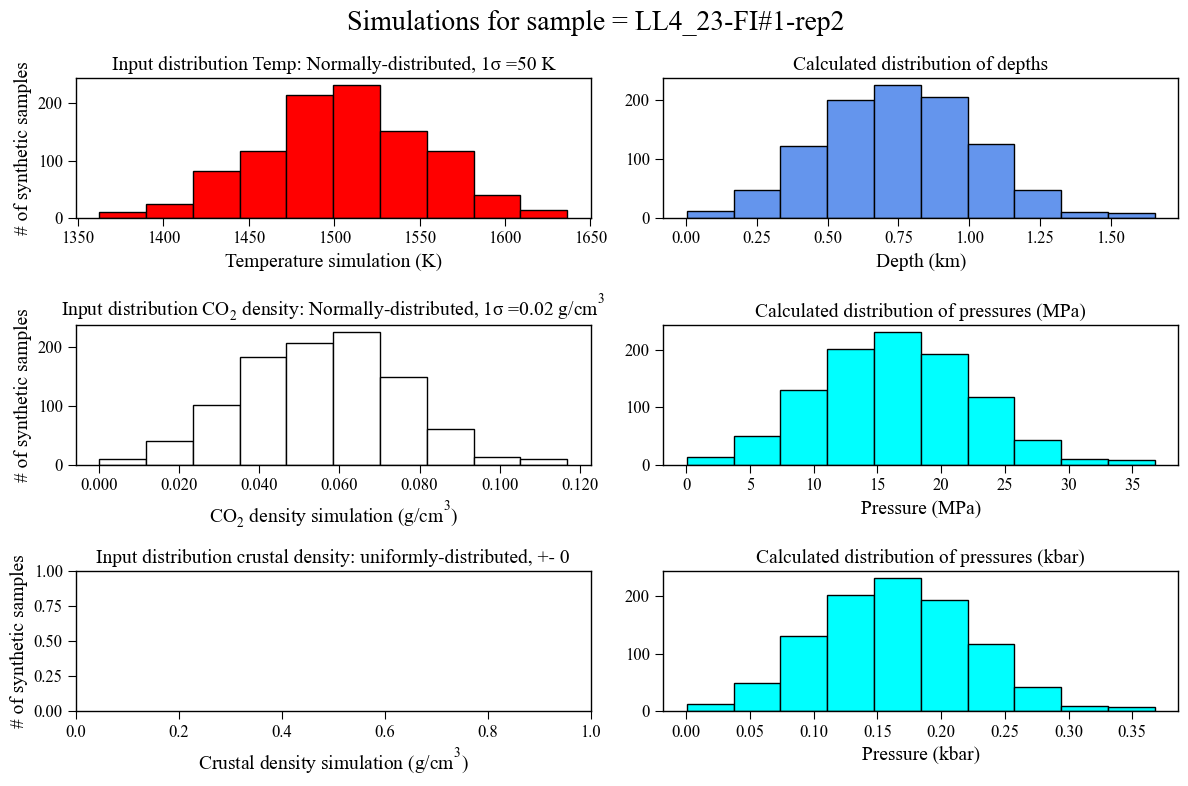

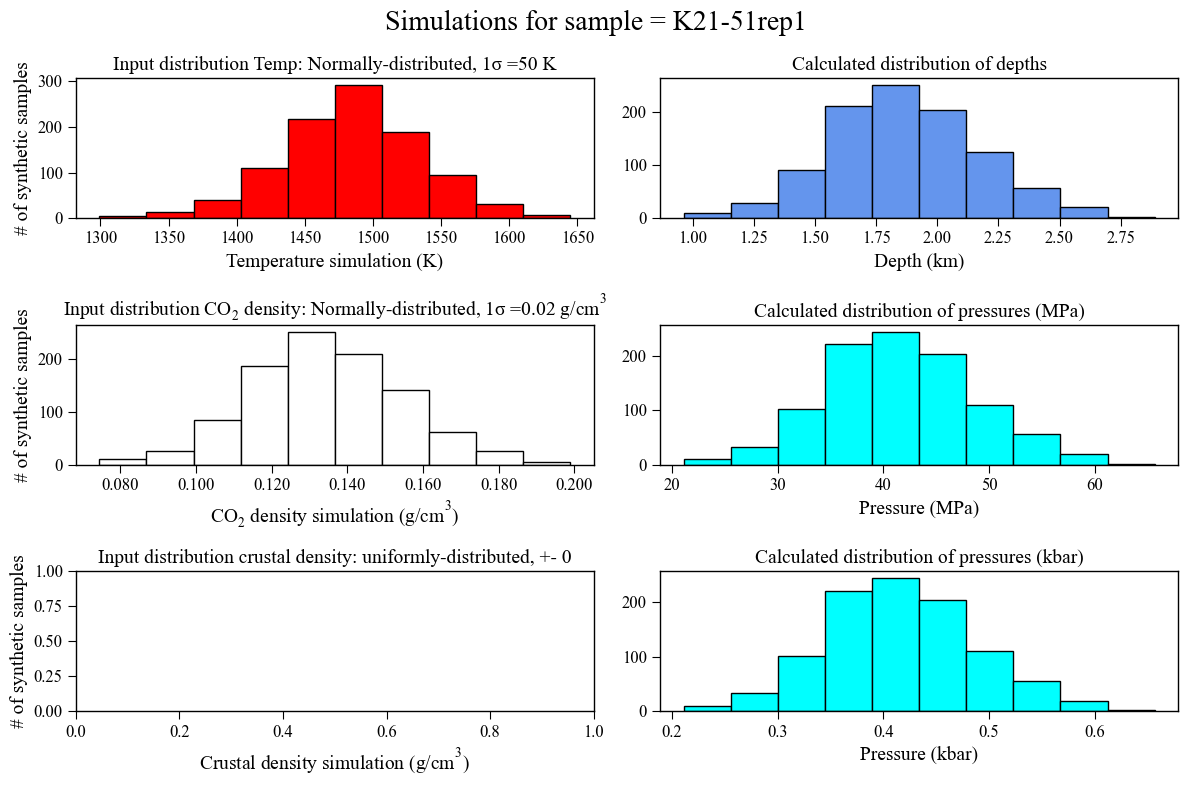

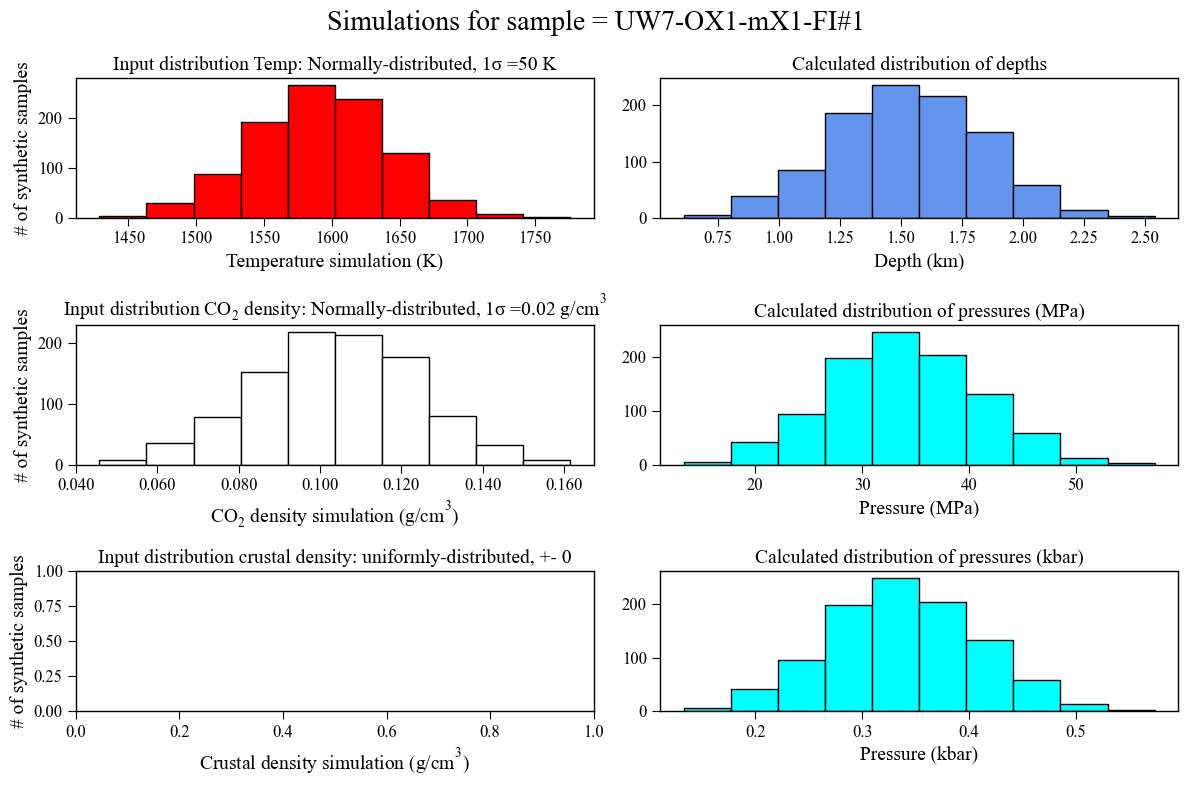

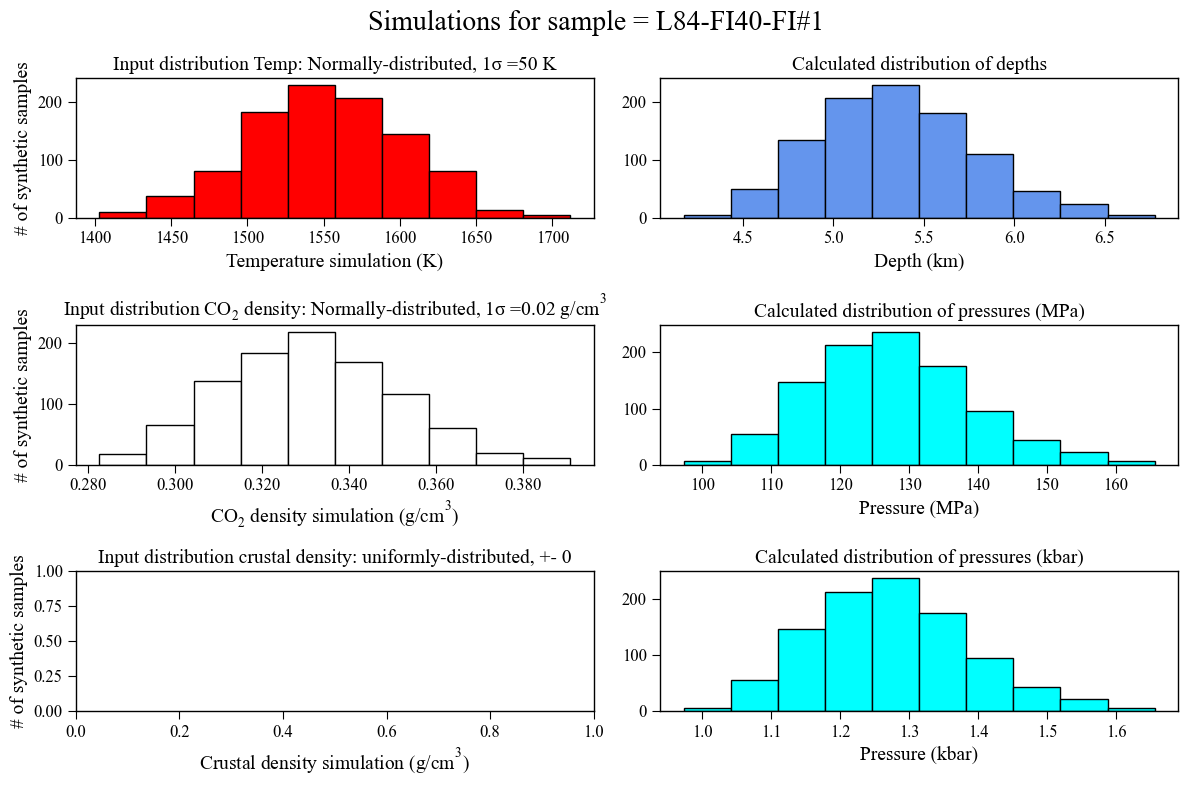

In [13]:
DP_dict={}
DP_all_dict={}
complete_dict={}

for dfs in dfs_wProbe_dict_filt_wleipw:
    print(dfs)

    DP, DP_all,fig=pf.propagate_FI_uncertainty(sample_ID=dfs_wProbe_dict_filt_wleipw[dfs]['filename_4match'],
                                                        CO2_dens_gcm3=dfs_wProbe_dict_filt_wleipw[dfs]['Preferred D'],
                                                        T_K=dfs_wProbe_dict_filt_wleipw[dfs]['T_calc_K'],
                                                        N_dup=1000,
                                                        crust_dens_kgm3=None, model='ryan_lerner',
                                                        error_T_K=50, error_type_T_K='Abs', error_dist_T_K='normal',
                                                        error_CO2_dens=0.02, error_type_CO2_dens='Abs', error_dist_CO2_dens='normal',
                                                        EOS='SW96',plot_figure=True
                                                        )
    
    DP_dict[dfs]=DP
    DP_all_dict[dfs]=DP_all
    DP_dict[dfs]['Sample_ID'] = DP_dict[dfs]['Filename'].apply(lambda x: next((s for s in ['LL8', 'LL7', 'LL4',
                                                                                           'UW',
                                                                                          'L84','K21'] if s in x), None))

    if dfs == lei:

        DP_dict[dfs]['Fo content (molar)']=dfs_wProbe_dict_filt_wleipw[dfs]['Fo content (molar)_merge']
    else:
        DP_dict[dfs]['Fo content (molar)']=dfs_wProbe_dict_filt_wleipw[dfs]['Fo content (molar)_CAM']
    
    complete_dict[dfs]=dfs_wProbe_dict_filt_wleipw[dfs].merge(DP_dict[dfs],how='left',left_on='filename_4match',right_on='Filename')


    #display(DP_dict[dfs].head(2))
    display(complete_dict[dfs].head(2))

complete_dict[lei].to_excel(compilation_folder+'/'+'Leilani_fullymerged.xlsx')
complete_dict_concat=pd.concat(complete_dict.values(), ignore_index=True)
complete_dict_concat.to_excel(compilation_folder+'/'+'Hawaii_fullymerged.xlsx')
#dfs_wProbe_dict_filt_wleipw[dfs]['1σ'] 4 error on fit error only

In [14]:
rep_FI=pd.read_excel(rep_FI_path)

test=pd.merge(complete_dict[lei],rep_FI, on="filename_4match")
# averaged_df = test.groupby('FI_name_reps', as_index=False).mean()
# averaged_df

# Identify numeric and non-numeric columns
df=test.copy()
numeric_columns = df.select_dtypes(include=[np.number]).columns
non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns

# Create a dictionary of aggregation functions for numeric columns
aggregation = {col: 'mean' for col in numeric_columns}

# For non-numeric columns, use the 'last' function to keep the last value in each group
for col in non_numeric_columns:
    aggregation[col] = 'last'

# Group by "FI_name_reps" and calculate the averages and keep the non-numeric columns
averaged_df = df.groupby('FI_name_reps', as_index=False).agg(aggregation)
cols_to_move = ['Sample_ID_y', 'Xtal','Fo content (molar)', 'FI_name_reps']

# Move the columns to the beginning of the DataFrame
for col in cols_to_move:
    averaged_df.insert(0, col, averaged_df.pop(col))

averaged_df.to_excel(compilation_folder+'/'+'Leilani_fullymerged_averaged.xlsx')
display(averaged_df.head())

### this part calculates and stores the standard deviations 

# Create a dictionary of aggregation functions for numeric columns
aggregation = {col: 'std' for col in numeric_columns}

# For non-numeric columns, use the 'last' function to keep the last value in each group
for col in non_numeric_columns:
    aggregation[col] = 'last'

# Group by "FI_name_reps" and calculate the averages and keep the non-numeric columns
std_df = df.groupby('FI_name_reps', as_index=False).agg(aggregation)
cols_to_move = ['Sample_ID_y', 'Xtal','Fo content (molar)', 'FI_name_reps']

# Move the columns to the beginning of the DataFrame
for col in cols_to_move:
    std_df.insert(0, col, std_df.pop(col))

std_df.to_excel(compilation_folder+'/'+'Leilani_fullymerged_averaged_stdeviations.xlsx')

,FI_name_reps,Fo content (molar),Xtal,Sample_ID_y,Corrected_Splitting,Corr_Split+1σ,Corr_Split-1σ,Corr_Split_1σ_val,Splitting,Split_err_abs,Split_err_quadrature,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,Diad1_Prop_Lor,Diad1_fwhm,Diad2_Combofit_Cent,Diad2_cent_err,Diad2_Combofit_Height,Diad2_Voigt_Cent,Diad2_Voigt_Area,Diad2_Voigt_Sigma,Diad2_Voigt_Gamma,Diad2_Residual,Diad2_Prop_Lor,Diad2_fwhm,HB1_Cent,HB1_Area,HB1_Sigma,HB2_Cent,HB2_Area,HB2_Sigma,C13_Cent,C13_Area,C13_Sigma,Diad2_Gauss_Cent,Diad2_Gauss_Area,Diad2_Gauss_Sigma,Diad1_Gauss_Cent,Diad1_Gauss_Area,Diad1_Gauss_Sigma,Day,power (mW),Int_time (s),accumulations,Mag (X),sec since midnight,Spectral Center,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,SO2_Diad_Ratio,T_K_x,Peak_Cent_Carb,Peak_Area_Carb,Peak_Height_Carb,Carb_Diad_Ratio,SO2-CO2_Arearatio,Number order,Probe no.,Weight P,CaO,TiO2,SiO2,Al2O3,MgO,FeO,MnO,NiO,Cr2O3,Total_x,Fo,Cation,Ca,Ti,Si,Al,Mg,Fe,Mn,Ni,Cr,Total .1,Counting_stats,Ca(Error%),Ti(Error%),Si(Error%),Al(Error%),Mg(Error%),Fe(Error%),Mn(Error%),Ni(Error%),Cr(Error%),D.L,Ca(D.L.),Ti(D.L.),Si(D.L.),Al(D.L.),Mg(D.L.),Fe(D.L.),Mn(D.L.),Ni(D.L.),Cr(D.L.),Fo content (molar)_x,Preferred D,dens-1σ,dens+1σ,1σ,LowD_RT,HighD_RT,LowD_SC,MedD_SC,HighD_SC,Fo content (molar)_CAM,% Fluid,Description,"Classification (1=bubble with fermi diad, 2=No bubble, 3=bubble but no fermi diad)","Na2O (wt%, measured)","Al2O3 (wt%, measured)","P2O5 (wt%, measured)","CaO (wt%, measured)","K2O (wt%, measured)","TiO2 (wt%, measured)","SiO2 (wt%, measured)","MgO (wt%, measured)","FeO (wt%, measured)","MnO (wt%, measured)",Total_y,"H2O (wt%, measured)","CO2 (ppm, measured)","Amount of PEC (%, calculated)","Na2O (wt%, PEC-corr)","Al2O3 (wt%, PEC-corr)","P2O5 (wt%, PEC-corr)","CaO (wt%, PEC-corr)","K2O (wt%, PEC-corr)","TiO2 (wt%, PEC-corr)","SiO2 (wt%, PEC-corr)","MgO (wt%, PEC-corr)","FeO (wt%, PEC-corr)","MnO (wt%, PEC-corr)","H2O (wt%) (wt%, PEC-corr)","CO2 (ppm) (wt%, PEC-corr)",Fo content (molar)_y,MgO (wt%),SiO2 (wt%),FeO (wt%),Unnamed: 35,Al2O3 (wt%),CaO (wt%),MnO (wt%),NiO (wt%),Melt inclusion Density (g/cm3),Vol Bubble/(Vol melt inclusion (excl bubble)) (%),Mean Δ (cm-1),Correction factor for drift,Standard deviation Δ (cm-1),CO2 density (g/cm3),CO2 in bubble (ppm),Upper 1 σ CO2 in bubble (ppm),Lower 1 σ CO2 in bubble (ppm),"Total CO2 (glass + bubble, ppm)",Total CO2 (PEC-corrected),"VolatileCalc Saturation pressure (measured glass CO2 and H2O content, no PEC-correction)","X CO2 (VolatileCalc, from glass only saturation pressure)",CO2 density EOS method @ 725C (g/cm3),CO2 density EOS method @ 825C (g/cm3),CO2 density EOS method @ 680C (g/cm3),"CO2 in bubble (EOS method, 725C, ppm)","Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)","Magmasat XCO2 (Total, PEC-corr CO2, Measured H2O)","Shishkina Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)","Iacono-Marziano Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)","VolatileCalc Saturation pressure (bar) (Total, PEC-corr CO2, Measured H2O)","VolatileCalc Saturation pressure macro (bar) (Total, PEC-corr CO2, Measured H2O)","VolatileCalc XCO2 (Total, PEC-corr CO2, Measured H2O)","Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, 0.5wt% H2O)","Magmasat XCO2 (Total, PEC-corr CO2, 0.5wt% H2O)","Shishkina Saturation Pressure (bar) (Total, PEC-corr CO2, 0.5wt% H2O)","Iacono-Marziano Saturation Pressure (bar) (Total, PEC-corr CO2, 0.5wt% H2O)","VolatileCalc Saturation pressure (bar) (Total, PEC-corr CO2, 0.5wt% H2O)","VolatileCalc Saturation pressure macro (bar) (Total, PEC-corr CO2, 0.5wt% H2O)","VolatileCalc XCO2 (Total, PEC-corr CO2, 0.5wt% H2O)",Diff (Measured H2O vs 0.5 wt% H2O - Magmasat),Diff (Measured H2O vs 0.5 wt% H2O - Shishkina),Diff (Measured H2O vs 0.5 wt% H2O - IM),Diff (Measured H2O vs 0.5 wt% H2O -VolatileCalc),"Magmasat Saturation Pressure Max CO2 (glass+bubble, PEC corr,+1 sigma splitting 

In [15]:
Fitextures=pd.read_excel(FI_texture_path)

display(Fitextures.head())
df_w_textures=pd.merge(averaged_df,Fitextures, on="FI_name_reps")

# Now we add a few useful columns in terms of error spotting
df_w_textures['percent_error_rho']=df_w_textures['1σ']*100/df_w_textures['Preferred D']
df_w_textures['percent_error_correctedsplit']=df_w_textures['Corr_Split_1σ_val']*100/df_w_textures['Corrected_Splitting']
df_w_textures['percent_error_diad1']=df_w_textures['Diad1_cent_err']*100/df_w_textures['Diad1_Combofit_Cent']
df_w_textures['percent_error_diad2']=df_w_textures['Diad2_cent_err']*100/df_w_textures['Diad2_Combofit_Cent']
## This is the yuan and mayanovic 2017 Intensity/FWHM criterion 
df_w_textures['diad1_yuan_maya_criterion']=df_w_textures['Diad1_Combofit_Height']/df_w_textures['Diad1_fwhm']
df_w_textures['diad2_yuan_maya_criterion']=df_w_textures['Diad2_Combofit_Height']/df_w_textures['Diad2_fwhm']

display(df_w_textures.head())

df_wstdevs=pd.merge(df_w_textures,std_df[['FI_name_reps','Corrected_Splitting','Day','Preferred D']],on='FI_name_reps')

df_wstdevs.to_excel(compilation_folder+'/'+'Leilani_fullymerged_averaged+textures_unfilteredbadspectra.xlsx')


,FI_name_reps,Xtal_name,MOUNT,MIorFI,melt?,Melt-Nomelt pair,% Fluid,Subxtal_subxtal_main,Position in Xtal,"Growth zone, PS, S?",Shape,Decrepit,Texturally Related/Unrelated,Comment
0,LL4_10-MI#1,LL4_10,L,MI,melt,No,72.527473,main,edge,Isolated,ellipsoid,y,UR,maybe related to decrep ring
1,LL4_12-FI#1,LL4_12,L,FI,no melt,Yes,100.000000,subxtal,center,GZ,ellipsoid,n,UR,In a subxtal
2,LL4_12-FI#2,LL4_12,L,FI,no melt,Yes,100.000000,subxtal,center,GZ,ellipsoid,n,UR,In a subxtal
3,LL4_12-MI#2,LL4_12,L,MI,melt,Yes,85.772358,subxtal,center,GZ,ellipsoid,n,UR,In a subxtal
4,LL4_23-FI#1,LL4_23,NaN,FI,no melt,No,100.000000,main,edge,GZ,edged,n,R,Focus problem? It's doubly refracted


,FI_name_reps,Fo content (molar),Xtal,Sample_ID_y,Corrected_Splitting,Corr_Split+1σ,Corr_Split-1σ,Corr_Split_1σ_val,Splitting,Split_err_abs,Split_err_quadrature,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,Diad1_Prop_Lor,Diad1_fwhm,Diad2_Combofit_Cent,Diad2_cent_err,Diad2_Combofit_Height,Diad2_Voigt_Cent,Diad2_Voigt_Area,Diad2_Voigt_Sigma,Diad2_Voigt_Gamma,Diad2_Residual,Diad2_Prop_Lor,Diad2_fwhm,HB1_Cent,HB1_Area,HB1_Sigma,HB2_Cent,HB2_Area,HB2_Sigma,C13_Cent,C13_Area,C13_Sigma,Diad2_Gauss_Cent,Diad2_Gauss_Area,Diad2_Gauss_Sigma,Diad1_Gauss_Cent,Diad1_Gauss_Area,Diad1_Gauss_Sigma,Day,power (mW),Int_time (s),accumulations,Mag (X),sec since midnight,Spectral Center,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,SO2_Diad_Ratio,T_K_x,Peak_Cent_Carb,Peak_Area_Carb,Peak_Height_Carb,Carb_Diad_Ratio,SO2-CO2_Arearatio,Number order,Probe no.,Weight P,CaO,TiO2,SiO2,Al2O3,MgO,FeO,MnO,NiO,Cr2O3,Total_x,Fo,Cation,Ca,Ti,Si,Al,Mg,Fe,Mn,Ni,Cr,Total .1,Counting_stats,Ca(Error%),Ti(Error%),Si(Error%),Al(Error%),Mg(Error%),Fe(Error%),Mn(Error%),Ni(Error%),Cr(Error%),D.L,Ca(D.L.),Ti(D.L.),Si(D.L.),Al(D.L.),Mg(D.L.),Fe(D.L.),Mn(D.L.),Ni(D.L.),Cr(D.L.),Fo content (molar)_x,Preferred D,dens-1σ,dens+1σ,1σ,LowD_RT,HighD_RT,LowD_SC,MedD_SC,HighD_SC,Fo content (molar)_CAM,% Fluid_x,Description,"Classification (1=bubble with fermi diad, 2=No bubble, 3=bubble but no fermi diad)","Na2O (wt%, measured)","Al2O3 (wt%, measured)","P2O5 (wt%, measured)","CaO (wt%, measured)","K2O (wt%, measured)","TiO2 (wt%, measured)","SiO2 (wt%, measured)","MgO (wt%, measured)","FeO (wt%, measured)","MnO (wt%, measured)",Total_y,"H2O (wt%, measured)","CO2 (ppm, measured)","Amount of PEC (%, calculated)","Na2O (wt%, PEC-corr)","Al2O3 (wt%, PEC-corr)","P2O5 (wt%, PEC-corr)","CaO (wt%, PEC-corr)","K2O (wt%, PEC-corr)","TiO2 (wt%, PEC-corr)","SiO2 (wt%, PEC-corr)","MgO (wt%, PEC-corr)","FeO (wt%, PEC-corr)","MnO (wt%, PEC-corr)","H2O (wt%) (wt%, PEC-corr)","CO2 (ppm) (wt%, PEC-corr)",Fo content (molar)_y,MgO (wt%),SiO2 (wt%),FeO (wt%),Unnamed: 35,Al2O3 (wt%),CaO (wt%),MnO (wt%),NiO (wt%),Melt inclusion Density (g/cm3),Vol Bubble/(Vol melt inclusion (excl bubble)) (%),Mean Δ (cm-1),Correction factor for drift,Standard deviation Δ (cm-1),CO2 density (g/cm3),CO2 in bubble (ppm),Upper 1 σ CO2 in bubble (ppm),Lower 1 σ CO2 in bubble (ppm),"Total CO2 (glass + bubble, ppm)",Total CO2 (PEC-corrected),"VolatileCalc Saturation pressure (measured glass CO2 and H2O content, no PEC-correction)","X CO2 (VolatileCalc, from glass only saturation pressure)",CO2 density EOS method @ 725C (g/cm3),CO2 density EOS method @ 825C (g/cm3),CO2 density EOS method @ 680C (g/cm3),"CO2 in bubble (EOS method, 725C, ppm)","Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)","Magmasat XCO2 (Total, PEC-corr CO2, Measured H2O)","Shishkina Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)","Iacono-Marziano Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)","VolatileCalc Saturation pressure (bar) (Total, PEC-corr CO2, Measured H2O)","VolatileCalc Saturation pressure macro (bar) (Total, PEC-corr CO2, Measured H2O)","VolatileCalc XCO2 (Total, PEC-corr CO2, Measured H2O)","Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, 0.5wt% H2O)","Magmasat XCO2 (Total, PEC-corr CO2, 0.5wt% H2O)","Shishkina Saturation Pressure (bar) (Total, PEC-corr CO2, 0.5wt% H2O)","Iacono-Marziano Saturation Pressure (bar) (Total, PEC-corr CO2, 0.5wt% H2O)","VolatileCalc Saturation pressure (bar) (Total, PEC-corr CO2, 0.5wt% H2O)","VolatileCalc Saturation pressure macro (bar) (Total, PEC-corr CO2, 0.5wt% H2O)","VolatileCalc XCO2 (Total, PEC-corr CO2, 0.5wt% H2O)",Diff (Measured H2O vs 0.5 wt% H2O - Magmasat),Diff (Measured H2O vs 0.5 wt% H2O - Shishkina),Diff (Measured H2O vs 0.5 wt% H2O - IM),Diff (Measured H2O vs 0.5 wt% H2O -VolatileCalc),"Magmasat Saturation Pressure Max CO2 (glass+bubble, PEC corr,+1 sigma splittin

These samples were excluded, rho error >20%, confirmed spectral constraint reason (i.e., too few points, too low intensity, too high/wavy background)


,FI_name_reps,percent_error_rho,diad1_yuan_maya_criterion,diad2_yuan_maya_criterion
4,LL4-21-MI#1,354.759804,68.379009,67.014967
6,LL4-21-MI#4,533.227953,57.457238,38.535453
8,LL4-21-MI#6,23.049922,61.086022,120.290641
30,LL4-FI12b-MI#2,25.638502,134.458286,279.892739
32,LL4-FI2,56.318842,146.427389,231.050358
43,LL4-FI7-#13,70.137538,39.340348,63.046673
49,LL4-FI7-#7,26.218647,41.101485,83.921913
62,LL4_23-FI#1,28.923920,170.271924,128.542853
71,LL7-19dp-#1,22.573778,220.283190,303.302908
72,LL7-19dp-#2,36.683939,161.640394,240.156217


These samples are used for future


,FI_name_reps,Fo content (molar),Xtal,Sample_ID_y,Corrected_Splitting_x,Corr_Split+1σ,Corr_Split-1σ,Corr_Split_1σ_val,Splitting,Split_err_abs,Split_err_quadrature,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,Diad1_Prop_Lor,Diad1_fwhm,Diad2_Combofit_Cent,Diad2_cent_err,Diad2_Combofit_Height,Diad2_Voigt_Cent,Diad2_Voigt_Area,Diad2_Voigt_Sigma,Diad2_Voigt_Gamma,Diad2_Residual,Diad2_Prop_Lor,Diad2_fwhm,HB1_Cent,HB1_Area,HB1_Sigma,HB2_Cent,HB2_Area,HB2_Sigma,C13_Cent,C13_Area,C13_Sigma,Diad2_Gauss_Cent,Diad2_Gauss_Area,Diad2_Gauss_Sigma,Diad1_Gauss_Cent,Diad1_Gauss_Area,Diad1_Gauss_Sigma,Day_x,power (mW),Int_time (s),accumulations,Mag (X),sec since midnight,Spectral Center,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,SO2_Diad_Ratio,T_K_x,Peak_Cent_Carb,Peak_Area_Carb,Peak_Height_Carb,Carb_Diad_Ratio,SO2-CO2_Arearatio,Number order,Probe no.,Weight P,CaO,TiO2,SiO2,Al2O3,MgO,FeO,MnO,NiO,Cr2O3,Total_x,Fo,Cation,Ca,Ti,Si,Al,Mg,Fe,Mn,Ni,Cr,Total .1,Counting_stats,Ca(Error%),Ti(Error%),Si(Error%),Al(Error%),Mg(Error%),Fe(Error%),Mn(Error%),Ni(Error%),Cr(Error%),D.L,Ca(D.L.),Ti(D.L.),Si(D.L.),Al(D.L.),Mg(D.L.),Fe(D.L.),Mn(D.L.),Ni(D.L.),Cr(D.L.),Fo content (molar)_x,Preferred D_x,dens-1σ,dens+1σ,1σ,LowD_RT,HighD_RT,LowD_SC,MedD_SC,HighD_SC,Fo content (molar)_CAM,% Fluid_x,Description,"Classification (1=bubble with fermi diad, 2=No bubble, 3=bubble but no fermi diad)","Na2O (wt%, measured)","Al2O3 (wt%, measured)","P2O5 (wt%, measured)","CaO (wt%, measured)","K2O (wt%, measured)","TiO2 (wt%, measured)","SiO2 (wt%, measured)","MgO (wt%, measured)","FeO (wt%, measured)","MnO (wt%, measured)",Total_y,"H2O (wt%, measured)","CO2 (ppm, measured)","Amount of PEC (%, calculated)","Na2O (wt%, PEC-corr)","Al2O3 (wt%, PEC-corr)","P2O5 (wt%, PEC-corr)","CaO (wt%, PEC-corr)","K2O (wt%, PEC-corr)","TiO2 (wt%, PEC-corr)","SiO2 (wt%, PEC-corr)","MgO (wt%, PEC-corr)","FeO (wt%, PEC-corr)","MnO (wt%, PEC-corr)","H2O (wt%) (wt%, PEC-corr)","CO2 (ppm) (wt%, PEC-corr)",Fo content (molar)_y,MgO (wt%),SiO2 (wt%),FeO (wt%),Unnamed: 35,Al2O3 (wt%),CaO (wt%),MnO (wt%),NiO (wt%),Melt inclusion Density (g/cm3),Vol Bubble/(Vol melt inclusion (excl bubble)) (%),Mean Δ (cm-1),Correction factor for drift,Standard deviation Δ (cm-1),CO2 density (g/cm3),CO2 in bubble (ppm),Upper 1 σ CO2 in bubble (ppm),Lower 1 σ CO2 in bubble (ppm),"Total CO2 (glass + bubble, ppm)",Total CO2 (PEC-corrected),"VolatileCalc Saturation pressure (measured glass CO2 and H2O content, no PEC-correction)","X CO2 (VolatileCalc, from glass only saturation pressure)",CO2 density EOS method @ 725C (g/cm3),CO2 density EOS method @ 825C (g/cm3),CO2 density EOS method @ 680C (g/cm3),"CO2 in bubble (EOS method, 725C, ppm)","Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)","Magmasat XCO2 (Total, PEC-corr CO2, Measured H2O)","Shishkina Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)","Iacono-Marziano Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)","VolatileCalc Saturation pressure (bar) (Total, PEC-corr CO2, Measured H2O)","VolatileCalc Saturation pressure macro (bar) (Total, PEC-corr CO2, Measured H2O)","VolatileCalc XCO2 (Total, PEC-corr CO2, Measured H2O)","Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, 0.5wt% H2O)","Magmasat XCO2 (Total, PEC-corr CO2, 0.5wt% H2O)","Shishkina Saturation Pressure (bar) (Total, PEC-corr CO2, 0.5wt% H2O)","Iacono-Marziano Saturation Pressure (bar) (Total, PEC-corr CO2, 0.5wt% H2O)","VolatileCalc Saturation pressure (bar) (Total, PEC-corr CO2, 0.5wt% H2O)","VolatileCalc Saturation pressure macro (bar) (Total, PEC-corr CO2, 0.5wt% H2O)","VolatileCalc XCO2 (Total, PEC-corr CO2, 0.5wt% H2O)",Diff (Measured H2O vs 0.5 wt% H2O - Magmasat),Diff (Measured H2O vs 0.5 wt% H2O - Shishkina),Diff (Measured H2O vs 0.5 wt% H2O - IM),Diff (Measured H2O vs 0.5 wt% H2O -VolatileCalc),"Magmasat Saturation Pressure Max CO2 (glass+bubble, PEC corr,+1 sigma sp

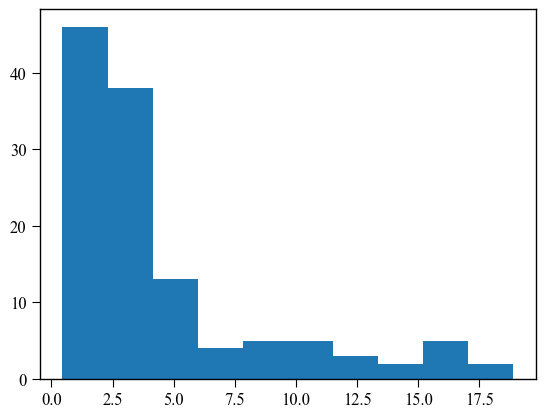

In [19]:
### Now let's do some filtering 

## First let's filter bad spectra out (very high back, bumpy, low intensity/fwhm, error 20% because of crappy spectral features)
x='diad1_yuan_maya_criterion'
x2='diad2_yuan_maya_criterion'
y='percent_error_rho'

percent_rho_err_cutoff=20
filter=(df_wstdevs[y]<percent_rho_err_cutoff)#~(df_wstdevs['diad1_yuan_maya_criterion']<200)&~(df_wstdevs['diad2_yuan_maya_criterion']<200)
df_wstdevs_filtered=df_wstdevs[filter]

# These are excluded from further analysis
print('These samples were excluded, rho error >20%, confirmed spectral constraint reason (i.e., too few points, too low intensity, too high/wavy background)')
display(df_wstdevs[df_wstdevs['percent_error_rho']>percent_rho_err_cutoff][['FI_name_reps','percent_error_rho',x,x2]])

print('These samples are used for future')
display(df_wstdevs_filtered.head())
df_wstdevs_filtered.to_excel(compilation_folder+'/'+'Leilani_fullymerged_averaged+textures_badout.xlsx')

plt.hist(df_wstdevs_filtered['percent_error_rho'],bins=10)
## Last filter out any with % FLUID less than 80 (ones we can be fairly certain are actually in the FI realm and not MI)

df_wstdevs_lastfilt=df_wstdevs_filtered[df_wstdevs_filtered['% Fluid_y']>=80]
df_wstdevs_lastfilt.to_excel(compilation_folder+'/'+'Leilani_fullymerged_averaged+textures.xlsx')

(0.0, 20.0)

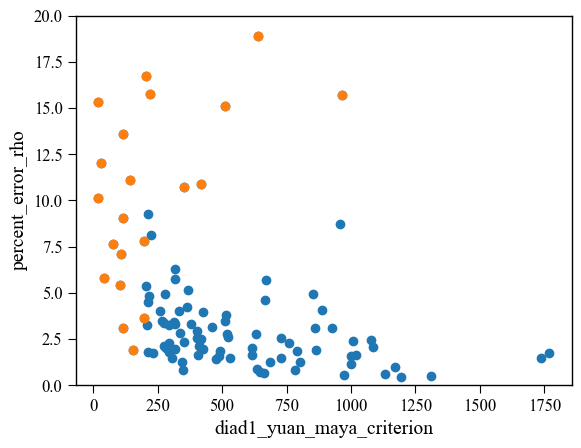

In [22]:
x='diad1_yuan_maya_criterion'
x2='diad2_yuan_maya_criterion'
y='percent_error_rho'

plt.scatter(df_wstdevs_lastfilt[x],df_wstdevs_lastfilt[y])
filter=(df_wstdevs_lastfilt[x]<200)+(df_wstdevs_lastfilt[x2]<200)+~(df_wstdevs_lastfilt[y]<10)
plt.scatter(df_wstdevs_lastfilt[x][filter],df_wstdevs_lastfilt[y][filter])
plt.xlabel(x)
plt.ylabel(y)
plt.ylim([0,20])